# Anova analysis of Line Task 2014 data

### 20151112

Author: Seb James <seb.james@sheffield.ac.uk>

## Data import

Import latency and error data which is computed from the raw data by
the script lt_analyse_all.m. This script saves the resulting data into
a Matlab v7 file.

See the Analysing Data.ipynb notebook for details about how the data
is organised. This notebook contains just the analysis.

This script requires the python modules scipy and statsmodels.


In [1]:
# Import the data, which should be available in Matlab v7 format. 
# fnames is used throughout the rest of this notebook, so this section needs to be evaluated!
import scipy.io as sio
mat_workspace = sio.loadmat('AllData/fnames.mat')
fnames = mat_workspace['fnames']


## Check the Data

### Per-index parameter check

Let's check the parameters for each index, making sure that the mean
jump time and the trial duration have their correct values of 0.8 s
and 120 s respectively.

*Make sure this runs and there aren't any PROBLEM messages in the output.*

In [2]:
index = 0
for fname in zip(*fnames):
    problem = 0
    if fname[1][0,0][0][0,0] != 120:
        print fname[0], ' does not have duration parameter = 120s! PROBLEM'
        problem = 1
    if fname[1][0,0][10][0,0] != 0.8:
        print fname[0], ' does not have tAtteso (jump time) parameter = 0.8s! PROBLEM'
        problem = 1
    if problem == 0:
        print 'Trial',index,fname[0][0], 'is a', fname[1][0,0][36][0], 'trial'
    index = index + 1
    if index > 12:
        print '...etc.'
        break

Trial 0 Jon/EF/line/20141118134208.txt is a Synchronous Distractor trial
Trial 1 Jon/EF/line/20141118133619.txt is a No Distractor trial
Trial 2 Jon/EF/line/20141118133914.txt is a Asynchronous Distractor trial
Trial 3 Jon/SF/line/20141125145758.txt is a No Distractor trial
Trial 4 Jon/SF/line/20141125145535.txt is a Synchronous Distractor trial
Trial 5 Jon/SF/line/20141125145313.txt is a Asynchronous Distractor trial
Trial 6 Jon/EJ/line/20141201164116.txt is a Asynchronous Distractor trial
Trial 7 Jon/EJ/line/20141201164343.txt is a No Distractor trial
Trial 8 Jon/EJ/line/20141201164607.txt is a Synchronous Distractor trial
Trial 9 Jon/EC2/line/20141118132305.txt is a Asynchronous Distractor trial
Trial 10 Jon/EC2/line/20141118132030.txt is a Synchronous Distractor trial
Trial 11 Jon/EC2/line/20141118131733.txt is a No Distractor trial
Trial 12 Jon/EW2_/line/20141202162631.txt is a Synchronous Distractor trial
...etc.


### On subject omission

Omitted subjects, with reasons:

EM1, KW, JD, LC, YC - Experimenter chose the wrong jump time on one or
more conditions.

AB2_ - Experimenter did not carry out a Synchronous Distractor trial

is132 - Age not recorded for this participant - could not match data
to participant in Spreadsheet.

### On event omission

The script lt_analyse_latency.m will try to produce accurate latencies
to first movement, along with direction errors from the time series
data in the 2014*.txt files. It omits some events for the following
reasons (grep for omit_reason in the .m code to find these):

* *Too fast* - Latency is too short; usually caused by the lack of a stable pre-event stylus position
* *No movement detected* - usually caused by a negligible target position change.
* *Previous event stableposition_index is >= current event onset*
* *target movement insignificant for event* - If the stylus's position since attaining the last event's target has an SD which is >abs(target_new-target_old), then omit the event.
* *Counting same motion as distraction due to event N instead* -  We must have counted an EARLIER distractor as having caused this movement. Mark that earlier distractor for omission and record in THIS event. Occurs when there are two distractor events in quick succession in the asynchronous condition.
* *Stylus moving at event onset* - subject did not settle prior to the event.
* *Stylus didn''t move away from target position before next distraction* - For distractors occurring at short time intervals. This is an omit_reason for a distractor event only.
* *Movement occurs beyond next target event and is in dirn of target* - this is an omit_reason for a distractor event only.
* *Failed to find a stable stylus period before this event* - subject did not settle
* *stable stylus period is too short* - subject did not settle for long enough

Later, when the individual analysis is called, a standard approach to
outlier removal is taken (see individual::excludeOutliers()).

## Anova analysis code

The following code provides a number of global functions and a class
which are used in the rest of this analysis.

The class called *individual* stores the latency data for each
individual.

### Look at target events, omissions, errors etc

This is mostly debugging/exploring.

In [39]:
from __future__ import division

import numpy as np
import random

def getfnameid (filename):
    # idarr[1] is the ID, idarr[0] is the experimenter, idarr[3] is the dated filename.
    idarr = filename.split('/')
    return idarr[1]

# From the condition string, return an index for the condition. 0 is 
# "No Distractor trial", 1 is "Synchronous Distractor trail", 2 is
# "Asynchronous Distractor trial".
def getcondition (condition_string):
    condition_index = -1
    if 'No Dist' in condition_string:
        condition_index = 0
    elif 'Synchro' in condition_string:
        condition_index = 1
    elif 'Asynchr' in condition_string:
        condition_index = 2
    return condition_index

# A Single Factor ANOVA calculation for three datasets
def group_anova(nodist_latencies,sync_latencies,async_latencies):

    all_latencies = np.concatenate((nodist_latencies, sync_latencies, async_latencies))
        
    # Compute grand mean
    grand_mean = all_latencies.mean()
    #print 'Grand mean:',grand_mean,'(',all_latencies.var(ddof=1),') not ',all_latencies.var(ddof=0)
        
    # Compute within-group variance
    tmp1 = all_latencies
    np.power(tmp1, 2)
    within_group_dof = all_latencies.size-3
    within_group_variance = tmp1.sum()/within_group_dof
    #print 'within_group_variance',within_group_variance
    
    nodist_mean = nodist_latencies.mean()
    sync_mean = sync_latencies.mean()
    async_mean = async_latencies.mean()
    
    # Compute amoung-group variance
    tmp1 = np.power (grand_mean - nodist_mean, 2)*nodist_latencies.size
    tmp2 = np.power (grand_mean - sync_mean, 2)*sync_latencies.size
    tmp3 = np.power (grand_mean - async_mean, 2)*async_latencies.size
    sosquares = tmp1 + tmp2 + tmp3
    between_group_dof = 2 # 3 conditions => 3 groups, so 3-1 DOF
    between_group_variance = sosquares / between_group_dof
    #print 'between_group_variance',between_group_variance
        
    # Now compute the F ratio
    F = between_group_variance/within_group_variance
        
    # Lastly, what's the probability for this?
    P = 1-special.fdtr(between_group_dof,within_group_dof,F)
        
    return (F, between_group_dof, within_group_dof, P)

# Convert an omit reason id to a reason string
def omit_reason (or_id):
    reason_str = ""
    if or_id == 0:
        reason_str = "0 not omitted"
    if or_id == 1:
        reason_str = "1 target posn change insignificant"
    elif or_id == 2:
        reason_str = "2 target posn held less than min. duration"
    elif or_id == 3:
        reason_str = "3 target posn change less than min. jump size"
    elif or_id == 4:
        reason_str = "4 Stable position later than event onset"
    elif or_id == 5:
        reason_str = "5 Another event caused this movement"
    elif or_id == 6:
        reason_str = "6 Not distracted"
    elif or_id == 7:
        reason_str = "7 Too fast (targ)" # faster than A.fastest_brain_decision
    elif or_id == 8:
        reason_str = "8 Too fast (distractor)" # faster than A.fastest_brain_decision
    elif or_id == 9:
        reason_str = "9 No movement detected"
    elif or_id == 10:
        reason_str = "10 Failed to find stable stylus posn"
    elif or_id == 11:
        reason_str = "11 Stable stylus period too short"
    elif or_id == 12:
        reason_str = "12 Drift too great during stable stylus period"
    elif or_id == 13:
        reason_str = "13 Drift too great during stable period (avg)"
    elif or_id == 14:
        reason_str = "14 Stylus moving at event onset"
    elif or_id == 15:
        reason_str = "15 Stylus didn't move away from target"
    elif or_id == 16:
        reason_str = "16 Movement occurs beyond next target"
    elif or_id == 17:
        reason_str = "17 Subject was distracted by closely previous distractor"
    elif or_id == 18:
        reason_str = "18 Incorrect move was recorded in previous distractor event"
    elif or_id == 19:
        reason_str = "19 This distractor event did not distract the stylus movement"
    elif or_id == 20:
        reason_str = "20 Recorded this stylus movement as a distraction towards the next distractor"


    return reason_str

# Take n sub-samples from distn
def subsample (distn, n):
    distn_cp = distn
    np.random.seed(19742016)
    counter = 0
    subsamp = []
    if n > len(distn_cp):
        print 'No possible to get',n,'samples from this distribution!'
        return subsamp
    while counter < n:
        i = 0
        for s in distn_cp:
            if np.random.uniform()>0.5:
                np.delete(distn_cp, i)
                i -= 1
                subsamp = np.append(subsamp, s)
                counter = counter + 1
            if counter >= n:
                break
            i += 1
    return subsamp

def compute_mad_outliers (points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    # Compute root mean square deviation from median:
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    # The median of this is the median abs. deviation from the median.
    med_abs_deviation = np.median(diff)
    # A modified Z score is analogous to the Z score for number of SDs from the mean.
    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def compute_mad (points):
    """
    Returns the median abs deviation value for the points

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations

    Returns:
    --------
        med_abs_deviation: The median absolute deviation

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    # Compute root mean square deviation from median:
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    # The median of this is the median abs. deviation from the median.
    med_abs_deviation = np.median(diff)
    return med_abs_deviation

# class individual has moved to its own file, as it was getting unwieldy here.
#import individual as individual

# Libs used in class individual
from scipy import special
from scipy import stats
import statsmodels.api as sm
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

# Class for an individual's data.
class individual:
    def __init__(self, subj_id):
        self.subj_id = subj_id;
        self.idnum = -1
        self.filename = ""

        # Default number of subsamples to take from a distribution
        self.numSubsamples = 20

        # All data, errorred and ok, for each condition.
        self.alldata_nd = np.ndarray(0)
        self.alldata_sd = np.ndarray(0)
        self.alldata_ad = np.ndarray(0)
        
        # These are the "non-movement-error target latencies"
        self.nodist_latencies = np.ndarray(0)
        self.sync_latencies = np.ndarray(0)
        self.async_latencies = np.ndarray(0)
        self.nodist_latencies_rank = np.ndarray(0)
        self.sync_latencies_rank = np.ndarray(0)
        self.async_latencies_rank = np.ndarray(0)

        # These are the "non-movement-error distractor latencies"
        self.nodist_dgood_latencies = np.ndarray(0)
        self.sync_dgood_latencies = np.ndarray(0)
        self.async_dgood_latencies = np.ndarray(0)
        self.nodist_dgood_latencies_rank = np.ndarray(0)
        self.sync_dgood_latencies_rank = np.ndarray(0)
        self.async_dgood_latencies_rank = np.ndarray(0)

        # These are the "target event error latencies"
        self.nodist_err_latencies = np.ndarray(0)
        self.sync_err_latencies = np.ndarray(0)
        self.async_err_latencies = np.ndarray(0)
        self.nodist_err_latencies_rank = np.ndarray(0)
        self.sync_err_latencies_rank = np.ndarray(0)
        self.async_err_latencies_rank = np.ndarray(0)

        # These are the "distractor event error latencies" (N/A for ND or for Sync, where target==distractor event)
        self.nodist_derr_latencies = np.ndarray(0)
        self.sync_derr_latencies = np.ndarray(0)
        self.async_derr_latencies = np.ndarray(0)
        self.nodist_derr_latencies_rank = np.ndarray(0)
        self.sync_derr_latencies_rank = np.ndarray(0)
        self.async_derr_latencies_rank = np.ndarray(0)

        self.n_errors_per_target_nd = 0
        self.n_errors_per_distractor_sync = 0
        self.n_errors_per_distractor_async = 0

        # Number of distractor events in the asynchronous case
        self.n_async_distractors = 0
        
        # Some constants
        self.DIST_EVENT = 0
        self.TARG_EVENT = 1

    def csvheader(self):
        hl = 'Experimenter,Subject,Distractor type,RT (M),RT (SD),N correct,RT incorrect (M),'
        hl += 'RT incorrect (SD),N incorrect,Error rate,D1 (-ve=>error)'
        for i in range(2,65):
            hl += ',D{0}'.format(i)
        hl += '\n'
        return hl

    def ad_omit_reasons (self, event_type):
        event_indices = [i for i,elem in enumerate(self.alldata_ad[:,1]) if elem == event_type]
        # Last col gives omit reason
        return np.bincount(self.alldata_ad[event_indices,6].astype(int),minlength=21)

    def sd_omit_reasons (self, event_type):
        event_indices = [i for i,elem in enumerate(self.alldata_sd[:,1]) if elem == event_type]
        # Last col gives omit reason
        return np.bincount(self.alldata_sd[event_indices,6].astype(int),minlength=21)

    def nd_omit_reasons (self, event_type):
        event_indices = [i for i,elem in enumerate(self.alldata_nd[:,1]) if elem == event_type]
        # Last col gives omit reason
        return np.bincount(self.alldata_nd[event_indices,6].astype(int),minlength=21)

    # Experimenter,Subject,Distractor type,RT (M),RT (SD),N correct,RT incorrect (M),
    # RT incorrect (SD),N incorrect,Error rate,Delays (negative = incorrect)
    def csvlineset(self):
        line = self.filename_nd + ',' + self.subj_id + ',0,'
        # ND mean/SD. NB: /1000 to output numbers as seconds, like Mauro reports.
        line += '{0},{1},'.format(self.nodist_mean()/1000,self.nodist_latencies.std()/1000)
        # ND RT incorrect mean/SD
        line += '{0},{1},{2},'.format(self.num_tgood(0),self.nodist_err_mean()/1000,self.nodist_err_std()/1000)
        # ND num incorrect, error rate
        line += '{0},{1}'.format(self.num_tmoveerrors(0),ind.num_tmoveerrors_percent(0))
        # ND delays
        #for i in self.nodist_latencies[:,1]:
        #    line += ',{0}'.format(i/1000)
        for i in self.alldata_nd:
            if i[5]==1:
                line += ',OR{0}'.format(self.omit_reason(i[6]))
            else:
                if i[2]==0: # ND and no error
                    line += ',{0}'.format(i[4]/1000)
                elif i[2]==1: # ND and error
                    # make errorred ones -ve as Mauro does.
                    line += ',{0}'.format(-i[4]/1000)
                    
        line += '\n'

        line += self.filename_sd + ',' + self.subj_id + ',1,'
        # SD mean/SD
        line += '{0},{1},'.format(self.sync_mean()/1000,self.sync_latencies.std()/1000)
        # SD RT incorrect mean/SD
        line += '{0},{1},{2},'.format(self.num_tgood(1),self.sync_err_mean()/1000,self.sync_err_std()/1000)
        # SD num incorrect, error rate
        line += '{0},{1}'.format(self.num_tmoveerrors(1),ind.num_tmoveerrors_percent(1))
        # SD delays
        #for i in self.sync_latencies[:,1]:
        #    line += ',{0}'.format(i/1000)
        for i in self.alldata_sd:
            if i[5]==1:
                line += ',OR{0}'.format(self.omit_reason(i[6]))
            else:
                if i[2]==0: # SD and no error
                    line += ',{0}'.format(i[4]/1000)
                elif i[2]==1: # SD and error
                    # make errorred ones -ve as Mauro does.
                    line += ',{0}'.format(-i[4]/1000)
        line += '\n'

        line += self.filename_ad + ',' + self.subj_id + ',2,'
        # AD mean/SD
        line += '{0},{1},'.format(self.async_latencies.mean()/1000,self.async_latencies.std()/1000)
        # AD RT incorrect mean/SD
        line += '{0},{1},{2},'.format(self.num_tgood(2),self.async_err_mean()/1000,self.async_err_std()/1000)
        # AD num incorrect, error rate
        line += '{0},{1}'.format(self.num_tmoveerrors(2),ind.num_tmoveerrors_percent(2))
        # AD delays
        #for i in self.async_latencies[:,1]:
        #    line += ',{0}'.format(i/1000)
        for i in self.alldata_ad:
            if i[5]==1:
                line += ',OR{0}'.format(self.omit_reason(i[6]))
            else:
                if i[1]==1 and i[2]==0: # TARG_EVENT and AD and no error
                    line += ',{0}'.format(i[4]/1000)
                elif i[1]==1 and i[2]==1: # TARG_EVENT and AD and error
                    # make errorred ones -ve as Mauro does.
                    line += ',{0}'.format(-i[4]/1000)
        line += '\n'

        return line

    # Compute ANOVA for this individual
    def anova(self):
        F, between_group_dof, within_group_dof, P = group_anova (self.nodist_latencies[:,1], self.sync_latencies[:,1], self.async_latencies[:,1])
        return (F, between_group_dof, within_group_dof, P)

    def reportmeans (self):
        print "Mean(SD): No distr: {0:.2f} ({1:.2f}) Sync: {2:.2f} ({3:.2f}) Async: {4:.2f} ({5:.2f})".format(self.nodist_mean(), self.nodist_std(), self.sync_mean(), self.sync_std(), self.async_mean(), self.async_std())

    # Batch up all data in a form suitable for statsmodel's MultiComparison class. This means
    # concatenating the ND, SD & AD data intoa single array, and making a "label" array to match.
    def getMultiComparisonData (self):
        d = np.hstack((self.nodist_latencies[:,1],self.sync_latencies[:,1],self.async_latencies[:,1]))

        nd_labels = np.ndarray(shape=(self.num_tgood(0),), dtype=object)
        nd_labels.fill('ND')

        sd_labels = np.ndarray(shape=(self.num_tgood(1),), dtype=object)
        sd_labels.fill('SD')

        ad_labels = np.ndarray(shape=(self.num_tgood(2),), dtype=object)
        ad_labels.fill('AD')

        l = np.hstack((nd_labels,sd_labels,ad_labels))

        # d is the data array, l is the label array.
        return (d, l)

    # Do a full set of graphs to show the normality of the data. Show QQ plots,
    # histograms of the distributions and results of Shapiro-Wilks tests for comparison.
    # Pass in the significance level for the S-W test.
    def shownormality (self, alpha):
        f, axarr = plt.subplots(3, 2)

        #ax1.set_title('QQ plots')
        fig1 = sm.qqplot(self.nodist_latencies[:,1], fit=True, line='45',ax=axarr[0,0])
        fig2 = sm.qqplot(self.sync_latencies[:,1], fit=True, line='45',ax=axarr[1,0])
        fig3 = sm.qqplot(self.async_latencies[:,1], fit=True, line='45', ax=axarr[2,0])
        axarr[0,0].set_title('QQ Plots')

        W, p = stats.shapiro (subsample(self.nodist_latencies[:,1], self.numSubsamples))
        isNormal = False
        if p > alpha:
            isNormal = True
        sw = 'ND. Mean/SD:{2:.2f}/{3:.2f} W={0:.2f}, p={1:.2f} (Normal:{4})'.format(W,p,self.nodist_mean(),self.nodist_std(),isNormal)
        axarr[0,1].hist(self.nodist_latencies[:,1], bins=20, label=sw)
        axarr[0,1].legend(prop={'size':9})
        axarr[0,1].set_title('Dist\'ns with Shapiro-Wilks stats')

        W, p = stats.shapiro (subsample(self.sync_latencies[:,1], self.numSubsamples))
        isNormal = False
        if p > alpha:
            isNormal = True
        sw = 'SD. Mean/SD:{2:.2f}/{3:.2f} W={0:.2f}, p={1:.2f} (Normal:{4})'.format(W,p,self.sync_mean(),self.sync_std(),isNormal)
        axarr[1,1].hist(self.sync_latencies[:,1], bins=20, label=sw)
        axarr[1,1].legend(prop={'size':9})

        W, p = stats.shapiro (subsample(self.async_latencies[:,1], self.numSubsamples))
        isNormal = False
        if p > alpha:
            isNormal = True
        sw = 'AD. Mean/SD:{2:.2f}/{3:.2f} W={0:.2f}, p={1:.2f} (Normal:{4})'.format(W,p,self.async_mean(),self.async_std(),isNormal)
        axarr[2,1].hist(self.async_latencies[:,1], bins=20, label=sw)
        axarr[2,1].legend(prop={'size':9})

        # Fine-tune figure; make subplots close to each other and hide x ticks for
        # all but bottom plot.
        f.subplots_adjust(hspace=0)
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

        savename = 'images/' + self.subj_id + 'normplot.png'
        plt.savefig(savename)
        plt.show()
        
    # Apply Shapiro-Wilk test. Null hypothesis is that the data are normally
    # distributed. If p < alpha then null hypothesis must be rejected and data
    # cannot be considered to be normally distributed.
    def shapiroWilk (self, condition, alpha):

        W = -1
        p = -1
        isNormal = False

        if condition == 0:
            W, p = stats.shapiro (subsample(self.nodist_latencies[:,1], self.numSubsamples))
        elif condition == 1:
            ss = subsample(self.sync_latencies[:,1], self.numSubsamples)
            W, p = stats.shapiro (ss)
        elif condition == 2:
            W, p = stats.shapiro (subsample(self.async_latencies[:,1], self.numSubsamples))
        # else leave W,p,isNormal with default values

        if p > alpha:
            isNormal = True

        return W, p, isNormal

    # Do a Quantile-Quantile plot to compare against normal distribution
    def qqplot (self):
        f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
        ax1.set_title('QQ plots',fontsize=18)
        fig1 = sm.qqplot(self.nodist_latencies[:,1], fit=True, line='45',ax=ax1)
        fig2 = sm.qqplot(self.sync_latencies[:,1], fit=True, line='45',ax=ax2)
        fig3 = sm.qqplot(self.async_latencies[:,1], fit=True, line='45', ax=ax3)
        # Fine-tune figure; make subplots close to each other and hide x ticks for
        # all but bottom plot.
        f.subplots_adjust(hspace=0)
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False, fontsize=18)
        plt.show()
        return f

    def boxplot (self):
        data = [self.nodist_latencies[:,1], self.sync_latencies[:,1], self.async_latencies[:,1]]
        plt.figure()
        plt.boxplot(data, 0, 'gD')
        nodist_cond_x = np.ones(self.nodist_latencies[:,1].size)-0.1
        sync_cond_x = 2*np.ones(self.sync_latencies[:,1].size)-0.1
        async_cond_x = 3*np.ones(self.async_latencies[:,1].size)-0.1
        nodist_pts = plt.scatter(nodist_cond_x, self.nodist_latencies[:,1])
        sync_pts = plt.scatter(sync_cond_x, self.sync_latencies[:,1])
        async_pts = plt.scatter(async_cond_x, self.async_latencies[:,1])
        plt.xlabel('Condition 1:ND 2:S 3:AS',fontsize=18)
        plt.ylabel('Latency (ms)',fontsize=18)
        savename = 'images/' + self.subj_id + 'boxplot.png'
        plt.savefig(savename)
        plt.show()

    # A standard method for excluding outliers
    def excludeOutliers (self, show_excluded=0):
        # Latency data
        #self.excludeApriori(100,1000)
        if show_excluded:
            print 'Excluding good movement outliers...'
        self.excludeOutliers_mad_based(3.5,show_excluded)
        # Error data:
        #self.excludeErrApriori(100,1000)
        if show_excluded:
            print 'Excluding error outliers...'
        self.excludeErrOutliers(3.5,show_excluded)# also mad based

    # Private version of excludeApriori
    def excludeApriori__(self,tooshort,toolong,latencies,alldata):
        if latencies.size < 2:
            return latencies,alldata
        # First delete too short from latencies, and corresponding entries from self.alldata:
        del_indices = [i for i,elem in enumerate(latencies[:,1]) if elem < tooshort]
        if del_indices:
            event_indices = latencies[[del_indices]][:,0]
            delmask_bool = np.in1d(latencies[:,0], event_indices, assume_unique=True)
            keepmask_bool = np.invert(delmask_bool)
            latencies = latencies[keepmask_bool]
            keepmask_bool = np.invert(np.in1d(alldata[:,0], event_indices, assume_unique=True))
            alldata = alldata[keepmask_bool]
        # Too long:
        del_indices = [i for i,elem in enumerate(latencies[:,1]) if elem > toolong]
        if del_indices:
            event_indices = latencies[[del_indices]][:,0]
            keepmask_bool = np.invert(np.in1d(latencies[:,0], event_indices, assume_unique=True))
            latencies = latencies[keepmask_bool]
            keepmask_bool = np.invert(np.in1d(alldata[:,0], event_indices, assume_unique=True))
            alldata = alldata[keepmask_bool]
        return latencies,alldata
            
    # Exclude recorded latencies based on Apriori knowledge that
    # latencies can't be too short, and if they're too long they're
    # not representative of the brain processes we are probing.
    def excludeApriori(self,tooshort,toolong):
        self.nodist_latencies,self.alldata_nd = self.excludeApriori__(tooshort,toolong,self.nodist_latencies,self.alldata_nd)
        self.sync_latencies,self.alldata_sd = self.excludeApriori__(tooshort,toolong,self.sync_latencies,self.alldata_sd)
        self.async_latencies,self.alldata_ad = self.excludeApriori__(tooshort,toolong,self.async_latencies,self.alldata_ad)

    def excludeErrApriori(self,tooshort,toolong):
        self.nodist_err_latencies,self.alldata_nd = self.excludeApriori__(tooshort,toolong,self.nodist_err_latencies,self.alldata_nd)
        self.sync_err_latencies,self.alldata_sd = self.excludeApriori__(tooshort,toolong,self.sync_err_latencies,self.alldata_sd)
        self.async_err_latencies,self.alldata_ad = self.excludeApriori__(tooshort,toolong,self.async_err_latencies,self.alldata_ad)
        self.async_derr_latencies,self.alldata_ad = self.excludeApriori__(tooshort,toolong,self.async_derr_latencies,self.alldata_ad)

    # subroutine of excludeOutliers_mad_based()
    def excludeOutliers_mad_based_(self, latencies, alldata, thresh, show_excluded=0):
        nd_outliers = compute_mad_outliers (latencies,thresh)
        # nd_outliers is a large array of True/False.
        # print 'nd_outliers:',nd_outliers
        del_indices = [i for i,elem in enumerate(nd_outliers) if elem == True]
        # del_indices are the indices of the True values in nd_outliers
        if not del_indices:
            return latencies,alldata
        
        # The event number is not the same as the index into latencies
        event_indices = latencies[[del_indices]][:,0]

        if show_excluded:
            values_to_delete = latencies[[del_indices]][:,1]
            print 'deleting the following events',event_indices,'which have values',values_to_delete
        
        keepmask_bool = np.invert(np.in1d(latencies[:,0], event_indices, assume_unique=True))
        latencies = latencies[keepmask_bool]
        # Remove same indices from self.alldata:
        keepmask_bool = np.invert(np.in1d(alldata[:,0], event_indices, assume_unique=True))
        alldata = alldata[keepmask_bool]
        return latencies,alldata

    # Exclude outliers from each latency set based on median absolute deviation method.
    def excludeOutliers_mad_based(self, thresh=3.5, show_excluded=0):
        if show_excluded:
            print 'exclude nodist latencies for subject ',self.subj_id,'filename',self.filename_nd
        self.nodist_latencies,self.alldata_nd = self.excludeOutliers_mad_based_(self.nodist_latencies,self.alldata_nd,thresh,show_excluded)
        if show_excluded:
            print 'exclude sync latencies for subject ',self.subj_id,'filename',self.filename_sd
        self.sync_latencies,self.alldata_sd = self.excludeOutliers_mad_based_(self.sync_latencies,self.alldata_sd,thresh,show_excluded)
        if show_excluded:
            print 'exclude async latencies for subject ',self.subj_id,'filename',self.filename_ad
        self.async_latencies,self.alldata_ad = self.excludeOutliers_mad_based_(self.async_latencies,self.alldata_ad,thresh,show_excluded)

    def excludeErrOutliers (self, num_sds, show_excluded):
        if show_excluded:
            print 'exclude nodist latencies for subject ',self.subj_id,'filename',self.filename_nd
        self.nodist_err_latencies,self.alldata_nd = self.excludeOutliers_mad_based_(self.nodist_err_latencies,self.alldata_nd,num_sds,show_excluded)
        if show_excluded:
            print 'exclude sync latencies for subject ',self.subj_id,'filename',self.filename_sd
        self.sync_err_latencies,self.alldata_sd = self.excludeOutliers_mad_based_(self.sync_err_latencies,self.alldata_sd,num_sds,show_excluded)
        if show_excluded:
            print 'exclude async latencies for subject ',self.subj_id,'filename',self.filename_ad
        self.async_err_latencies,self.alldata_ad = self.excludeOutliers_mad_based_(self.async_err_latencies,self.alldata_ad,num_sds,show_excluded)

    def randomly_subsample_data (self, num_data):
        random.seed(19742016)
        while len(self.nodist_latencies[:,1]) > num_data:
            remove_this = random.randint (0,len(self.nodist_latencies[:,1])-1)
            self.nodist_latencies = np.delete(self.nodist_latencies, remove_this, axis=0)
        while len(self.sync_latencies[:,1]) > num_data:
            remove_this = random.randint (0,len(self.sync_latencies[:,1])-1)
            self.sync_latencies = np.delete(self.sync_latencies, remove_this, axis=0)
        while len(self.async_latencies[:,1]) > num_data:
            remove_this = random.randint (0,len(self.async_latencies[:,1])-1)
            self.async_latencies = np.delete(self.async_latencies, remove_this, axis=0)

    def graph1(self):
        print 'Showing graph for ', ind.subj_id
        means = (self.nodist_mean(), self.sync_mean(), self.async_mean())
        stds = (self.nodist_std(), self.sync_std(), self.async_std())
        index = np.arange(3)
        opacity = 0.4
        error_config = {'ecolor': '0.3'}
        rects1 = plt.bar(index, means, 0.2,
                 alpha=opacity,
                 color='b',
                 yerr=stds,
                 error_kw=error_config,
                 label=ind.subj_id)
        # Now draw the points on a scatter graph
        nodist_cond_x = np.zeros(self.nodist_latencies[:,1].size)
        sync_cond_x = np.ones(self.sync_latencies[:,1].size)
        async_cond_x = 2*np.ones(self.async_latencies[:,1].size)
        nodist_pts = plt.scatter(nodist_cond_x, self.nodist_latencies)
        sync_pts = plt.scatter(sync_cond_x, self.sync_latencies)
        async_pts = plt.scatter(async_cond_x, self.async_latencies)
        plt.xlabel('Condition 0:ND 1:S 2:AS')
        plt.ylabel('Latency (ms)')
        plt.title(self.subj_id)
        plt.show()
        return

    # Compute the sum of the squared displacements from the mean for all three conditions
    def sumofsquare_displacements_all_from_value(self, value):
        sos = self.sumofsquare_displacements_from_value(0,value) + self.sumofsquare_displacements_from_value(1,value) + self.sumofsquare_displacements_from_value(2,value)
        return sos

    # Compute the sum of the squared displacements from the mean for all three conditions
    def sumofsquare_displacements_all(self):
        sos = self.sumofsquare_displacements(0) + self.sumofsquare_displacements(1) + self.sumofsquare_displacements(2)
        return sos

    # Compute the sum of the squared displacements from the mean for the given condition
    def sumofsquare_displacements(self, condition):
        if condition == 0:
            mn = self.nodist_mean()
            squares = np.power((self.nodist_latencies[:,1] - mn), 2)
        elif condition == 1:
            mn = self.sync_mean()
            squares = np.power((self.sync_latencies[:,1] - mn), 2)
        else: # condition 2
            mn = self.async_mean()
            squares = np.power((self.async_latencies[:,1] - mn), 2)
        sos = np.sum(squares)
        return sos

    # Compute the sum of the squared displacements from the mean for the given condition
    def sumofsquare_displacements_from_value(self, condition, value):
        if condition == 0:
            squares = np.power((self.nodist_latencies[:,1] - value), 2)
            # Verification of this method:
            #squares_alt = 0
            #for i in self.nodist_latencies:
            #    imv = i - value
            #    squares_alt += imv*imv
            #print 'nd sum of squares:',np.sum(squares),'squares_alt:',squares_alt
        elif condition == 1:
            squares = np.power((self.sync_latencies[:,1] - value), 2)
        else: # condition 2
            squares = np.power((self.async_latencies[:,1] - value), 2)
        sos = np.sum(squares)
        return sos

    def alldata_for_condition(self, condition):
        if condition == 0:
            thedata = self.alldata_nd
        elif condition == 1:
            thedata = self.alldata_sd
        else: # condition 2
            thedata = self.alldata_ad
        return thedata

    def num_target_omissions(self, condition):
        thedata = self.alldata_for_condition(condition)
        # Select rows for which omit==1:
        omit_indices = [i for i,elem in enumerate(thedata[:,5]) if elem == 1]
        num_omit = 0
        if omit_indices:
            # From those rows, select those for which event type is target (1)
            omit_target_indices = [i for i,elem in enumerate(thedata[omit_indices,1]) if elem == 1]
            if omit_target_indices:
                num_omit = thedata[[omit_target_indices]][:,4].size

        return num_omit

    def num_target_non_omissions(self, condition):
        thedata = self.alldata_for_condition(condition)
        # Select rows for which omit==0:
        nomit_indices = [i for i,elem in enumerate(thedata[:,5]) if elem == 0]
        num_nomit = 0
        if nomit_indices:
            # From those rows, select those for which event type is target (1)
            nomit_target_indices = [i for i,elem in enumerate(thedata[nomit_indices,1]) if elem == 1]
            if nomit_target_indices:
                num_nomit = thedata[[nomit_target_indices]][:,4].size

        return num_nomit

    def num_distractor_events(self, condition):

        # In ND case, num_distractor_events == 0 by definition
        num = 0
        if condition == 0:
            return num

        # In SD case, num_distractor_events == num_target_events
        if condition == 1:
            return self.num_target_events(condition)

        thedata = self.alldata_for_condition(condition)
        distractor_indices = [i for i,elem in enumerate(thedata[:,1]) if elem == 0]
        if distractor_indices:
            num = thedata[[distractor_indices]][:,4].size
        return num

    def num_target_events(self, condition):
        thedata = self.alldata_for_condition(condition)
        distractor_indices = [i for i,elem in enumerate(thedata[:,1]) if elem == 1]
        num = 0
        if distractor_indices:
            num = thedata[[distractor_indices]][:,4].size
        return num

    def num_distractor_omissions(self, condition):
        thedata = self.alldata_for_condition(condition)

        # Select rows for which omit==1:
        omit_indices = [i for i,elem in enumerate(thedata[:,5]) if elem == 1]
        num_omit = 0
        if omit_indices:
            # From those rows, select those for which event type is distractor (0)
            omit_distractor_indices = [i for i,elem in enumerate(thedata[omit_indices,1]) if elem == 0]
            if omit_distractor_indices:
                num_omit = thedata[[omit_distractor_indices]][:,4].size

        return num_omit

    def num_distractor_non_omissions(self, condition):
        thedata = self.alldata_for_condition(condition)

        # Select rows for which omit==0:
        nomit_indices = [i for i,elem in enumerate(thedata[:,5]) if elem == 0]
        num_nomit = 0
        if nomit_indices:
            # From those rows, select those for which event type is distractor (0)
            nomit_distractor_indices = [i for i,elem in enumerate(thedata[nomit_indices,1]) if elem == 0]
            if nomit_distractor_indices:
                num_nomit = thedata[[nomit_distractor_indices]][:,4].size

        return num_nomit

    # Should be called num_tgood
    def num_tgood(self, condition):
        if condition == 0:
            if self.nodist_latencies.size<2:
                 return 0
            return self.nodist_latencies[:,1].size
        elif condition == 1:
            if self.sync_latencies.size<2:
                 return 0
            return self.sync_latencies[:,1].size
        else: # condition 2
            if self.async_latencies.size<2:
                 return 0
            return self.async_latencies[:,1].size

    # num_tgood_all
    def num_tgood_all(self):
        n = self.num_tgood(0) + self.num_tgood(1) + self.num_tgood(2)
        return n

    # num_tgood_percent. Number of good movements as a percentage of number of target events
    def num_tgood_percent(self, condition):
        if condition == 0:
            if self.nodist_latencies.size<2:
                 return 0
            return 100*self.nodist_latencies[:,1].size/self.num_target_events(condition)
        elif condition == 1:
            if self.sync_latencies.size<2:
                 return 0
            return 100*self.sync_latencies[:,1].size/self.num_target_events(condition)
        else: # condition 2
            if self.async_latencies.size<2:
                 return 0
            #prop_targets_non_omitted = self.num_target_non_omissions(condition)/self.num_target_events(condition)
            #representative_num_distractors = prop_targets_non_omitted * self.num_distractor_events(condition)
            return 100*self.async_latencies[:,1].size/self.num_target_events(condition)

    # moveerrors are "errors for target movements"
    def num_tmoveerrors_all(self):
        n = self.num_tmoveerrors(0) + self.num_tmoveerrors(1) + self.num_tmoveerrors(2)
        return n

    # Number of target movement errors
    def num_tmoveerrors(self, condition):
        
        #print 'num_tmoveerrors(',condition,') called'
        if condition == 0:
            #print 'nodist_err_latencies.size:',self.nodist_err_latencies.size
            if self.nodist_err_latencies.size<2:
                #print 'Returning 0 for nodist_err_latencies:',self.nodist_err_latencies
                return 0
            elif self.nodist_err_latencies.size == 2:
                #print 'Returning 1 for nodist_err_latencies:',self.nodist_err_latencies
                return 1
            #print 'Returning [:,1].size for nodist_err_latencies'
            return self.nodist_err_latencies[:,1].size
        elif condition == 1:
            #print 'sync_err_latencies.size:',self.sync_err_latencies.size
            if self.sync_err_latencies.size<2:
                 return 0
            elif self.sync_err_latencies.size == 2:
                return 1
            return self.sync_err_latencies[:,1].size
        else: # condition 2
            #print 'async_err_latencies.size:',self.async_err_latencies.size
            if self.async_err_latencies.size<2:
                 return 0
            elif self.async_err_latencies.size == 2:
                return 1
            return self.async_err_latencies[:,1].size

    # Number of target movement errors as a percentage of number of target events
    def num_tmoveerrors_percent(self, condition):
        if condition == 0:
            if self.nodist_err_latencies.size<2:
                 return 0
            return 100*self.nodist_err_latencies[:,1].size/self.num_target_non_omissions(condition)
        elif condition == 1:
            if self.sync_err_latencies.size<2:
                 return 0
            return 100*self.sync_err_latencies[:,1].size/self.num_target_non_omissions(condition)
        else: # condition 2
            if self.async_err_latencies.size<2:
                 return 0
            return 100*self.async_err_latencies[:,1].size/self.num_target_non_omissions(condition)
    
    # dmoverrors are : Distractor move errors
    def num_dmoveerrors_all(self):
        n = self.num_dmoveerrors(0) + self.num_dmoveerrors(1) + self.num_dmoveerrors(2)
        return n

    def num_dmoveerrors(self, condition):
        if condition == 0:
            if self.nodist_derr_latencies.size<2:
                 return 0
            return self.nodist_derr_latencies[:,1].size
        elif condition == 1:
            if self.sync_derr_latencies.size<2:
                 return 0
            return self.sync_derr_latencies[:,1].size
        else: # condition 2
            if self.async_derr_latencies.size<2:
                 return 0
            return self.async_derr_latencies[:,1].size

    # number of detected distractor errors as a percentage of the
    # total number of distractor events
    def num_dmoveerrors_percent(self, condition):
        if condition == 0:
            return 0 # 0 by definition
        elif condition == 1:
            if self.sync_derr_latencies.size<2:
                 return 0
            return 100*self.sync_derr_latencies[:,1].size/self.num_distractor_events(condition)
        else: # condition 2
            if self.async_derr_latencies.size<2:
                 return 0
            return 100*self.async_derr_latencies[:,1].size/self.num_distractor_events(condition)

    # Total number of movement errors (target and distractor) as a
    # percentage of the number of target events not omitted
    def num_moveerrors_per_target_percent(self, condition):
        moveerrors_percent = 0
        if condition == 0:
            # same as num_tmoveerrors_percent:
            moveerrors_percent = self.num_tmoveerrors_percent(condition)
        elif condition == 1:
            numerr = self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition)
            moveerrors_percent = 100 * numerr / self.num_target_non_omissions(condition)
        else: # condition == 2
            numerr = self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition)
            moveerrors_percent = 100 * numerr / self.num_target_non_omissions(condition)
        return moveerrors_percent

    # as above, but not as a percentage
    def num_moveerrors_per_target(self, condition):
        moveerrors_ = 0
        if condition == 0 or condition == 1:
            # same as num_tmoveerrors_ for the ND and SD cases
            moveerrors_ = self.num_tmoveerrors_percent(condition)/100
        else: # condition == 2
            numerr = self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition)
            moveerrors_ = 100 * numerr / self.num_target_non_omissions(condition)
        return moveerrors_

    # Total number of movement errors as a percentage of "the
    # proportion of all distractor events matching the proportion of
    # target events not omitted from latency measurement"
    def num_moveerrors_per_distractor_percent(self, condition):
        moveerrors_percent = 0
        prop_target_events = self.num_target_non_omissions(condition)/self.num_target_events(condition)
        if condition == 0:
            moveerrors_percent = -1 # nan really
        elif condition == 1:
            # For the SD condition, target moveerrors == distractor moveerrors
            moveerrors_percent = self.num_moveerrors_per_target_percent(condition)
        else: # condition == 2
            numerr = self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition)
            moveerrors_percent = 100 * numerr / self.num_distractor_events(condition)*prop_target_events
        return moveerrors_percent

    # dgood : Distractor events without a move error
    def num_dgood_all(self):
        n = self.num_dgood(0) + self.num_dgood(1) + self.num_dgood(2)
        return n

    def num_dgood(self, condition):
        if condition == 0:
            if self.nodist_dgood_latencies.size<2:
                return 0
            return self.nodist_dgood_latencies[:,1].size
        elif condition == 1:
            if self.sync_dgood_latencies.size<2:
                return 0
            return self.sync_dgood_latencies[:,1].size
        else: # condition 2
            if self.async_dgood_latencies.size<2:
                return 0
            return self.async_dgood_latencies[:,1].size

    def num_dgood_percent(self, condition):
        if condition == 0:
            if self.nodist_dgood_latencies.size<2:
                return 0
            return 100*self.nodist_dgood_latencies[:,1].size/(self.num_tgood(condition)+self.num_dgood(condition)+self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition))
        elif condition == 1:
            if self.sync_dgood_latencies.size<2:
                return 0
            return 100*self.sync_dgood_latencies[:,1].size/(self.num_tgood(condition)+self.num_dgood(condition)+self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition))
        else: # condition 2
            if self.async_dgood_latencies.size<2:
                return 0
            return 100*self.async_dgood_latencies[:,1].size/(self.num_tgood(condition)+self.num_dgood(condition)+self.num_tmoveerrors(condition)+self.num_dmoveerrors(condition))

    def nodist_mean(self):
        if self.nodist_latencies.size<2:
            return 0
        return self.nodist_latencies[:,1].mean()

    def sync_mean(self):
        if self.sync_latencies.size<2:
            return 0
        return self.sync_latencies[:,1].mean()

    def async_mean(self):
        if self.async_latencies.size<2:
            return 0
        return self.async_latencies[:,1].mean()

    def overall_mean(self):
        all_latencies = np.concatenate((self.nodist_latencies, self.sync_latencies, self.async_latencies))
        return all_latencies[:,1].mean()

    def overall_std(self):
        all_latencies = np.concatenate((self.nodist_latencies, self.sync_latencies, self.async_latencies))
        return all_latencies[:,1].std()

    def nodist_std(self):
        if self.nodist_latencies.size<2:
            return 0
        return self.nodist_latencies[:,1].std()

    def sync_std(self):
        if self.sync_latencies.size<2:
            return 0
        return self.sync_latencies[:,1].std()

    def async_std(self):
        if self.async_latencies.size<2:
            return 0
        return self.async_latencies[:,1].std()

    # mean/std accessors for the error latencies:
    def nodist_err_mean(self):
        if self.nodist_err_latencies.size<2:
            return 0
        return self.nodist_err_latencies.mean()

    def sync_err_mean(self):
        if self.sync_err_latencies.size<2:
            return 0
        return self.sync_err_latencies.mean()

    def async_err_mean(self):
        if self.async_err_latencies.size<2:
            return 0
        return self.async_err_latencies.mean()

    def overall_err_mean(self):
        all_err_latencies = np.concatenate((self.nodist_err_latencies, self.sync_err_latencies, self.async_err_latencies))
        return all_err_latencies[:,1].mean()

    def overall_err_std(self):
        all_err_latencies = np.concatenate((self.nodist_err_latencies, self.sync_err_latencies, self.async_err_latencies))
        return all_err_latencies[:,1].std()

    def nodist_err_std(self):
        if self.nodist_err_latencies.size<2:
            return 0
        return self.nodist_err_latencies.std()

    def sync_err_std(self):
        if self.sync_err_latencies.size<2:
            return 0
        return self.sync_err_latencies.std()

    def async_err_std(self):
        if self.async_err_latencies.size<2:
            return 0
        return self.async_err_latencies.std()

    # mean/std accessors for the distractor error latencies:
    def nodist_derr_mean(self):
        if self.nodist_derr_latencies.size<2:
            return 0
        return self.nodist_derr_latencies.mean()

    def sync_derr_mean(self):
        if self.sync_derr_latencies.size<2:
            return 0
        return self.sync_derr_latencies.mean()

    def async_derr_mean(self):
        if self.async_derr_latencies.size<2:
            return 0
        return self.async_derr_latencies.mean()

    def overall_derr_mean(self):
        all_derr_latencies = np.concatenate((self.nodist_derr_latencies, self.sync_derr_latencies, self.async_derr_latencies))
        return all_derr_latencies[:,1].mean()

    def overall_derr_std(self):
        all_derr_latencies = np.concatenate((self.nodist_derr_latencies, self.sync_derr_latencies, self.async_derr_latencies))
        return all_derr_latencies[:,1].std()

    def nodist_derr_std(self):
        if self.nodist_derr_latencies.size<2:
            return 0
        return self.nodist_derr_latencies.std()

    def sync_derr_std(self):
        if self.sync_derr_latencies.size<2:
            return 0
        return self.sync_derr_latencies.std()

    def async_derr_std(self):
        if self.async_derr_latencies.size<2:
            return 0
        return self.async_derr_latencies.std()

    # mean/std accessors for the distractor non-movement-error latencies:
    def nodist_dgood_mean(self):
        if self.nodist_dgood_latencies.size<2:
            return 0
        return self.nodist_dgood_latencies.mean()

    def sync_dgood_mean(self):
        if self.sync_dgood_latencies.size<2:
            return 0
        return self.sync_dgood_latencies.mean()

    def async_dgood_mean(self):
        if self.async_dgood_latencies.size<2:
            return 0
        return self.async_dgood_latencies.mean()

    def overall_dgood_mean(self):
        all_dgood_latencies = np.concatenate((self.nodist_dgood_latencies, self.sync_dgood_latencies, self.async_dgood_latencies))
        return all_dgood_latencies[:,1].mean()

    def overall_dgood_std(self):
        all_dgood_latencies = np.concatenate((self.nodist_dgood_latencies, self.sync_dgood_latencies, self.async_dgood_latencies))
        return all_dgood_latencies[:,1].std()

    def nodist_dgood_std(self):
        if self.nodist_dgood_latencies.size<2:
            return 0
        return self.nodist_dgood_latencies.std()

    def sync_dgood_std(self):
        if self.sync_dgood_latencies.size<2:
            return 0
        return self.sync_dgood_latencies.std()

    def async_dgood_std(self):
        if self.async_dgood_latencies.size<2:
            return 0
        return self.async_dgood_latencies.std()
    
    def report_movements(self,cond):
        if cond==0:
            str = '   ND'
        elif cond==1:
            str = '   Sync'
        else:
            print 'cond=',cond
            str = '   Async'
        
        print str,'non-error target movements',ind.num_tgood(cond),'-',100*ind.num_tgood(cond)/(ind.num_tgood(cond)+ind.num_dgood(cond)+ind.num_tmoveerrors(cond)+ind.num_dmoveerrors(cond)),'%'
        print str,'non-error distractor events',ind.num_dgood(cond),'-',100*ind.num_dgood(cond)/(ind.num_tgood(cond)+ind.num_dgood(cond)+ind.num_tmoveerrors(cond)+ind.num_dmoveerrors(cond)),'%'
        print str,'target movement errors:',ind.num_tmoveerrors(cond),'-',100*ind.num_tmoveerrors(cond)/(ind.num_tgood(cond)+ind.num_dgood(cond)+ind.num_tmoveerrors(cond)+ind.num_dmoveerrors(cond)),'%'
        print str,'distractor movement errors:',ind.num_dmoveerrors(cond),'-',100*ind.num_dmoveerrors(cond)/(ind.num_tgood(cond)+ind.num_dgood(cond)+ind.num_tmoveerrors(cond)+ind.num_dmoveerrors(cond)),'%'
        print str,'total events:',ind.num_tgood(cond)+ind.num_tmoveerrors(cond)+ind.num_dmoveerrors(cond),'total errors:',ind.num_tmoveerrors(cond)+ind.num_dmoveerrors(cond)
        print ''

    def __str__(self):
        return "Data container for subject {0}".format(self.subj_id)

    # Output for two factor anova analysis
    def outputDataForSPSS(self):
        for lat in self.nodist_latencies[:,1]:
            print '{0},ND,{1}'.format(self.subj_id,lat)
        for lat in self.sync_latencies[:,1]:
            print '{0},SD,{1}'.format(self.subj_id,lat)
        for lat in self.async_latencies[:,1]:
            print '{0},AD,{1}'.format(self.subj_id,lat)

    def outputDataForR(self):
        # R doesn't like 'NA' in a field - it reads it as "not available".
        if self.subj_id == 'NA':
            self.subj_id = 'NA_';
        line = '{2},{1},0,ND,{0}\n'.format(self.subj_id,self.nodist_latencies[:,1].mean(),self.idnum)
        line += '{2},{1},1,SD,{0}\n'.format(self.subj_id,self.sync_latencies[:,1].mean(),self.idnum)
        line += '{2},{1},2,AD,{0}\n'.format(self.subj_id,self.async_latencies[:,1].mean(),self.idnum)
        return line

    # Write out per-individual data for analysis in R
    def writeDataForR(self):
        dfname = 'IndDat' + self.subj_id + '.csv'


        theheader = "latency,condition_str\n"
        minsize = np.min([self.nodist_latencies[:,1].size,self.sync_latencies[:,1].size,self.async_latencies[:,1].size])
        _nd = subsample(self.nodist_latencies[:,1], minsize)
        _sd = subsample(self.sync_latencies[:,1], minsize)
        _ad = subsample(self.async_latencies[:,1], minsize)

        f = open(dfname, 'w')
        f.write(theheader)
        for i in range(1,minsize):
            line = "{0},ND\n{1},SD\n{2},AD\n".format(_nd[i],_sd[i],_ad[i])
            f.write(line)
        f.close()

    # Output for univariate or multivariate repeated measures analysis
    def outputDataForSPSS_MV(self):
        print '{0},ND,{1},{2}'.format(self.subj_id,self.nodist_latencies[:,1].mean(),self.n_errors_per_target_nd)
        print '{0},SD,{1},{2}'.format(self.subj_id,self.sync_latencies[:,1].mean(),self.n_errors_per_distractor_sync)
        print '{0},AD,{1},{2}'.format(self.subj_id,self.async_latencies[:,1].mean(),self.n_errors_per_distractor_async)

    # Output for repeated measures analysis of latency
    def outputDataForSPSS_RepMeasLat(self):
        print '{0},{1},{2},{3}'.format(self.subj_id,self.nodist_latencies.mean(),self.sync_latencies.mean(),self.async_latencies.mean())

    # Output for repeated measures analysis of error rate
    def outputDataForSPSS_RepMeasError(self):
        print '{0},{1},{2},{3}'.format(self.subj_id,self.n_errors_per_target_nd,self.n_errors_per_distractor_sync,self.n_errors_per_distractor_async)

### END CLASS individual ###

# This function sets up a list of individuals and populates the latencies.
def readIndividuals():
    individuals = dict()
    idnum_counter = 1
    # Extract the data from the raw format and collate it into individual
    # data containers, one per subject.
    for fname in zip(*fnames):
        # I'll use the subject ID as a key into output data structures
        subj_id = getfnameid(fname[0][0])

        # condition index is for the no distractor/sync distractor/async distractor
        condition_index = getcondition(fname[1][0,0][36][0])

        # Need ONE individual object for each subj_id.
        if subj_id not in individuals:
            individuals[subj_id] = individual(subj_id) # or if imported individual.individual(subj_id)
            individuals[subj_id].idnum = idnum_counter
            idnum_counter += 1

        # latencies for all events
        #
        # All the fname[n] contain:
        # ev.number, ev.type, ev.error, ev.correct_move, ev.latency. Then add on the condition.
        #
        # fname[2] additionally has: ev.omit and omit_reason (as a
        # numeric code) cols. So can obtain a value for "proportion of
        # targets omitted".
        #       
        #if individuals[subj_id].alldata.size < 2:
        #    individuals[subj_id].alldata = np.append(fname[2], condition_index*np.ones(fname[2].shape[0])[:,None], axis=1)
        #else:
        #    newdata = np.append(fname[2], condition_index*np.ones(fname[2].shape[0])[:,None], axis=1)
        #    individuals[subj_id].alldata = np.concatenate((individuals[subj_id].alldata,newdata),axis=0) # R.latency - Contains all data

        # latencies for non-movement-error target events
        tnoerr_latencies = fname[4] # R.latency_noerror_target - Use table with python index 4 - "no move error", "target event".
        
        # latencies for non-movement-error distractor events
        dnoerr_latencies = fname[5]
        
        # err_latencies = fname[6] # ALL error events, distractor and target.
        
        # latencies for target movement error events
        terr_latencies = fname[7] # R.latency_error_target
        
        # latencies for distractor movement error events
        derr_latencies = fname[8] # R.latency_error_distractor

        #omitted = fname[1] # omitted events?
        
        if condition_index == 0:
            individuals[subj_id].alldata_nd = fname[2]
            #print 'alldata_nd has shape', fname[2].shape
            individuals[subj_id].filename_nd = fname[0][0]

            #print err_latencies
            individuals[subj_id].nodist_latencies = tnoerr_latencies[:,[0,4]]
            individuals[subj_id].nodist_latencies_rank = stats.rankdata(individuals[subj_id].nodist_latencies[:,1])
            if terr_latencies.size > 0:
                individuals[subj_id].nodist_err_latencies = terr_latencies[:,[0,4]]
                individuals[subj_id].nodist_err_latencies_rank = stats.rankdata(individuals[subj_id].nodist_err_latencies[:,1])
            # We'll have an error rate for nodist - it should be very low. Did it get passed in?
            nerrs = 0
            ntargets = 0
            for d in individuals[subj_id].alldata_nd:
                ntargets += 1 # "ndistractors" is really "ntargets" for the ND condition.
                if d[2] > 0.0:
                    nerrs += 1
            individuals[subj_id].n_errors_per_target_nd = (float(nerrs) / float(ntargets))

        elif condition_index == 1:
            individuals[subj_id].alldata_sd = fname[2]
            individuals[subj_id].filename_sd = fname[0][0]
            #print latencies
            individuals[subj_id].sync_latencies = tnoerr_latencies[:,[0,4]]
            individuals[subj_id].sync_latencies_rank = stats.rankdata(individuals[subj_id].sync_latencies[:,1])
            if terr_latencies.size > 0:
                individuals[subj_id].sync_err_latencies = terr_latencies[:,[0,4]]
                individuals[subj_id].sync_err_latencies_rank = stats.rankdata(individuals[subj_id].sync_err_latencies[:,1])
            # For sync, also read errors
            nerrs = 0
            ndistractors = 0
            #if subj_id == 'JS':
            #    print 'Sync'
            for d in individuals[subj_id].alldata_sd:
                #if subj_id == 'JS' and d[2] > 0.0:
                #    print d
                ndistractors += 1
                if d[2] > 0.0:
                    nerrs += 1
            individuals[subj_id].n_errors_per_distractor_sync = (float(nerrs) / float(ndistractors))

        elif condition_index == 2:
            individuals[subj_id].alldata_ad = fname[2]
            individuals[subj_id].filename_ad = fname[0][0]
            individuals[subj_id].async_latencies = tnoerr_latencies[:,[0,4]]
            individuals[subj_id].async_latencies_rank = stats.rankdata(individuals[subj_id].async_latencies[:,1])
            #test[test[:, 1] == 4]
            if terr_latencies.size > 0:
                individuals[subj_id].async_err_latencies = terr_latencies[:,[0,4]]
                individuals[subj_id].async_err_latencies_rank = stats.rankdata(individuals[subj_id].async_err_latencies[:,1])
            if derr_latencies.size > 0:
                individuals[subj_id].async_derr_latencies = derr_latencies[:,[0,4]]
                individuals[subj_id].async_derr_latencies_rank = stats.rankdata(individuals[subj_id].async_derr_latencies[:,1])            
            # For async, also read errors
            nerrs = 0
            ndistractors = 0
            #if subj_id == 'JS':
            #    print 'Async'
            for d in individuals[subj_id].alldata_ad:
                #if subj_id == 'JS' and d[2] > 0.0:
                #    print d
                if d[2] > 0.0: # Count all errors for async
                    nerrs += 1
                if d[1] < 1.0:
                    ndistractors += 1
            #if subj_id == 'JS':
            #    print 'Num movement errors:',nerrs,'Num distractor events:',ndistractors
            individuals[subj_id].n_errors_per_distractor_async = (float(nerrs) / float(ndistractors))
            individuals[subj_id].n_async_distractors = ndistractors

    return individuals

# This function reads in data from Mauro's Summary.csv, producing the same list of individuals
# as is generated by readIndividuals()
import csv
def readMauroIndividuals ():
    with open('Mauro_analysis/Summary.csv', 'rb') as csvfile:
        
        individuals = dict()
        idnum_counter = 1
        first = 1
        dreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        
        for row in dreader:
            
            # Skip first row (the header)
            if first:
                first = 0
                continue

            # Can access rows by column number:
            #print row[3]
            #print row
            #print len(row)
            #break
            
            subj_id = row[1]
            exp_name = row[0]

            # condition index is for the no distractor/sync distractor/async distractor
            condition_index = int(row[2])

            # Need ONE individual object for each subj_id.
            if subj_id not in individuals:
                individuals[subj_id] = individual(subj_id)
                individuals[subj_id].idnum = idnum_counter
                individuals[subj_id].numSubsamples = 8
                idnum_counter += 1

            # No filename in Mauro's csv, just put name in each:
            individuals[subj_id].filename_nd = exp_name
            individuals[subj_id].filename_ad = exp_name
            individuals[subj_id].filename_sd = exp_name

            #individuals[subj_id].alldata_nd=np.ndarray(5)

            # latencies for non-movement-error target events
            ##tnoerr_latencies = fname[4] # R.latency_noerror_target - Use table with python index 4 - "no move error", "target event".
            # latencies for non-movement-error distractor events
            ##dnoerr_latencies = fname[5]
            # err_latencies = fname[6] # ALL error events, distractor and target.
            # latencies for target movement error events
            ##terr_latencies = fname[7] # R.latency_error_target
            # latencies for distractor movement error events
            ##derr_latencies = fname[8] # R.latency_error_distractor
            if condition_index == 0:
                i=10 # starting col for the latencies in Mauro's spreadsheet
                while i < len(row):
                    if len(row[i]) == 0:
                       break
                    rowval = float(row[i])
                    # New latency:
                    newlat = np.array([i+1,rowval])
                    if (rowval >= 0):
                        # number, type (TARG=1 here), error, correct_move, latency
                        newalldata = np.array([i+1, 1, 0, 1, rowval])
                        if individuals[subj_id].nodist_latencies.size == 0:
                            individuals[subj_id].nodist_latencies = newlat
                        else:
                            individuals[subj_id].nodist_latencies = np.vstack((individuals[subj_id].nodist_latencies, newlat))
                    else:
                        newalldata = np.array([i+1, 1, 1, 0, rowval])
                        if individuals[subj_id].nodist_err_latencies.size == 0:
                            individuals[subj_id].nodist_err_latencies = -1*newlat
                        else:
                            individuals[subj_id].nodist_err_latencies = np.vstack((individuals[subj_id].nodist_err_latencies, -1*newlat))

                    if individuals[subj_id].alldata_nd.size == 0:
                        individuals[subj_id].alldata_nd = newalldata
                    else:
                        individuals[subj_id].alldata_nd = np.vstack((individuals[subj_id].alldata_nd, newalldata))

                    #print 'alldata',individuals[subj_id].alldata_nd
                    i+=1
                # Compute ranks
                #print 'nodist latencies:',individuals[subj_id].nodist_latencies
                #print 'nodist_err latencies:',individuals[subj_id].nodist_err_latencies
                if individuals[subj_id].nodist_latencies.size>0:
                   individuals[subj_id].nodist_latencies_rank = stats.rankdata(individuals[subj_id].nodist_latencies[:,1])
                if individuals[subj_id].nodist_err_latencies.size>0:
                    if individuals[subj_id].nodist_err_latencies.size==2:
                        individuals[subj_id].nodist_err_latencies_rank = [1]
                    else:
                        individuals[subj_id].nodist_err_latencies_rank = stats.rankdata(individuals[subj_id].nodist_err_latencies[:,1])
                
                # nerrs code identical to that in readIndividuals
                nerrs = 0
                ntargets = 0
                for d in individuals[subj_id].alldata_nd:
                    ntargets += 1 # "ndistractors" is really "ntargets" for the ND condition.
                    if d[2] > 0.0:
                        nerrs += 1
                individuals[subj_id].n_errors_per_target_nd = (float(nerrs) / float(ntargets))
                #print individuals[subj_id].n_errors_per_target_nd 

            if condition_index == 1:
                i=10 # starting col for the latencies in Mauro's spreadsheet
                while i < len(row):
                    if len(row[i]) == 0:
                       break
                    rowval = float(row[i])
                    # New latency:
                    newlat = np.array([i+1,rowval])
                    if (rowval >= 0):
                        # number, type (TARG=1 here), error, correct_move, latency
                        newalldata = np.array([i+1, 1, 0, 1, rowval])
                        if individuals[subj_id].sync_latencies.size == 0:
                            individuals[subj_id].sync_latencies = newlat
                        else:
                            individuals[subj_id].sync_latencies = np.vstack((individuals[subj_id].sync_latencies, newlat))
                    else:
                        newalldata = np.array([i+1, 1, 1, 0, rowval])
                        if individuals[subj_id].sync_err_latencies.size == 0:
                            individuals[subj_id].sync_err_latencies = -1*newlat
                        else:
                            individuals[subj_id].sync_err_latencies = np.vstack((individuals[subj_id].sync_err_latencies, -1*newlat))

                    if individuals[subj_id].alldata_sd.size == 0:
                        individuals[subj_id].alldata_sd = newalldata
                    else:
                        individuals[subj_id].alldata_sd = np.vstack((individuals[subj_id].alldata_sd, newalldata))

                    #print 'alldata',individuals[subj_id].alldata_sd
                    i+=1
                #print 'sync latencies:',individuals[subj_id].sync_latencies
                #print 'sync_err latencies:',individuals[subj_id].sync_err_latencies
                # Compute ranks
                if individuals[subj_id].sync_latencies.size>0:
                    individuals[subj_id].sync_latencies_rank = stats.rankdata(individuals[subj_id].sync_latencies[:,1])
                if individuals[subj_id].sync_err_latencies.size>0:
                    if individuals[subj_id].sync_err_latencies.size==2:
                        individuals[subj_id].sync_err_latencies_rank = [1]
                    else:
                        individuals[subj_id].sync_err_latencies_rank = stats.rankdata(individuals[subj_id].sync_err_latencies[:,1])
                
                # nerrs code identical to that in readIndividuals
                nerrs = 0
                ntargets = 0
                for d in individuals[subj_id].alldata_sd:
                    ntargets += 1 # "ndistractors" is really "ntargets" for the ND condition.
                    if d[2] > 0.0:
                        nerrs += 1
                individuals[subj_id].n_errors_per_distractor_sync = (float(nerrs) / float(ntargets))
                #print individuals[subj_id].n_errors_per_distractor_sync 

            if condition_index == 2:
                # FIXME: FINISH ME
                i=10 # starting col for the latencies in Mauro's spreadsheet
                while i < len(row):
                    if len(row[i]) == 0:
                       break
                    rowval = float(row[i])
                    # New latency:
                    newlat = np.array([i+1,rowval])
                    if (rowval >= 0):
                        # number, type (TARG=1 here), error, correct_move, latency
                        newalldata = np.array([i+1, 1, 0, 1, rowval])
                        if individuals[subj_id].async_latencies.size == 0:
                            individuals[subj_id].async_latencies = newlat
                        else:
                            individuals[subj_id].async_latencies = np.vstack((individuals[subj_id].async_latencies, newlat))
                    else:
                        newalldata = np.array([i+1, 1, 1, 0, rowval])
                        if individuals[subj_id].async_err_latencies.size == 0:
                            individuals[subj_id].async_err_latencies = -1*newlat
                        else:
                            individuals[subj_id].async_err_latencies = np.vstack((individuals[subj_id].async_err_latencies, -1*newlat))

                    if individuals[subj_id].alldata_ad.size == 0:
                        individuals[subj_id].alldata_ad = newalldata
                    else:
                        individuals[subj_id].alldata_ad = np.vstack((individuals[subj_id].alldata_ad, newalldata))

                    #print 'alldata',individuals[subj_id].alldata_ad
                    i+=1
                #print 'async latencies:',individuals[subj_id].async_latencies
                #print 'async_err latencies:',individuals[subj_id].async_err_latencies
                # Compute ranks
                if individuals[subj_id].async_latencies.size>0:
                    individuals[subj_id].async_latencies_rank = stats.rankdata(individuals[subj_id].async_latencies[:,1])
                if individuals[subj_id].async_err_latencies.size>0:
                    if individuals[subj_id].async_err_latencies.size==2:
                        individuals[subj_id].async_err_latencies_rank = [1]
                    else:
                        individuals[subj_id].async_err_latencies_rank = stats.rankdata(individuals[subj_id].async_err_latencies[:,1])
                
                # nerrs code identical to that in readIndividuals
                nerrs = 0
                ntargets = 0
                for d in individuals[subj_id].alldata_ad:
                    ntargets += 1 # "ndistractors" is really "ntargets" for the ND condition.
                    if d[2] > 0.0:
                        nerrs += 1
                individuals[subj_id].n_errors_per_distractor_async = (float(nerrs) / float(ntargets))
                #print individuals[subj_id].n_errors_per_distractor_async 

    return individuals

def equaliseReplicates(individuals):
    # Find smallest number of cell replications and reduce all cells to this number.
    smallest_n = 1000000
    for i in individuals:
        individuals[i].excludeOutliers()
        if individuals[i].num_tgood(0) < smallest_n:
            smallest_n = individuals[i].num_tgood(0)
        if individuals[i].num_tgood(1) < smallest_n:
            smallest_n = individuals[i].num_tgood(1)
        if individuals[i].num_tgood(2) < smallest_n:
            smallest_n = individuals[i].num_tgood(2)

    # Randomly select smallest_n data from each condition in each individual
    for i in individuals:
        individuals[i].randomly_subsample_data(smallest_n)
    
    return individuals


In [15]:
#
# This is the definitive example of how to find out the number of
# target & distractor errors and the number of omitted events.
#
for i,ind in readIndividuals().iteritems():
    #print ind
    print 'ND'
    print 'num target events:', ind.num_target_events(0)
    print 'num distractor events:', ind.num_distractor_events(0)
    print 'num_target_omissions:',ind.num_target_omissions(0)
    print 'num_tgood:',ind.num_tgood(0)
    print 'num_tmoveerrors',ind.num_tmoveerrors(0)
    print 'num_target_non_omissions (should equal num_tgood + num_tmoveerrors):',ind.num_target_non_omissions(0)
    print 'tmoveerrors percent', ind.num_tmoveerrors_percent(0)
    print 'dmoveerrors percent', ind.num_dmoveerrors_percent(0)
    print 'moveerrors per target percent', ind.num_moveerrors_per_target_percent(0)
    print 'moveerrors per distractor percent', ind.num_moveerrors_per_distractor_percent(0)
    print 'num_target_non_omissions',ind.num_target_non_omissions(0)
    print 'num_target_omissions',ind.num_target_omissions(0)
    print 'num_distractor_non_omissions',ind.num_distractor_non_omissions(0)
    print 'num_distractor_omissions',ind.num_distractor_omissions(0)


    print 'SD'
    print 'num target events:', ind.num_target_events(1)
    print 'num distractor events:', ind.num_distractor_events(1)
    print 'num_target_omissions:',ind.num_target_omissions(1)
    print 'num_tgood:',ind.num_tgood(1)
    print 'num_tmoveerrors',ind.num_tmoveerrors(1)
    print 'num_target_non_omissions (should equal num_tgood + num_tmoveerrors):',ind.num_target_non_omissions(1)
    ##
    print 'tmoveerrors percent', ind.num_tmoveerrors_percent(1)
    print 'dmoveerrors percent', ind.num_dmoveerrors_percent(1)
    print 'moveerrors per target percent', ind.num_moveerrors_per_target_percent(1)
    print 'moveerrors per distractor percent', ind.num_moveerrors_per_distractor_percent(1)
    print 'num_target_non_omissions',ind.num_target_non_omissions(1)
    print 'num_target_omissions',ind.num_target_omissions(1)
    print 'num_distractor_omissions:',ind.num_distractor_omissions(1)
    print 'num_distractor_non_omissions:',ind.num_distractor_non_omissions(1)

    print 'AD'
    print 'num target events:', ind.num_target_events(2)
    print 'num distractor events:', ind.num_distractor_events(2)
    print 'num_target_omissions:',ind.num_target_omissions(2)
    print 'num_tgood:',ind.num_tgood(2)
    print 'num_tmoveerrors',ind.num_tmoveerrors(2)
    print 'num_target_non_omissions (num_tgood+tmoveerrors):',ind.num_target_non_omissions(2)
    print 'num_dgood:',ind.num_dgood(2)
    print 'num_dmoveerrors',ind.num_dmoveerrors(2)
    ##
    print 'tmoveerrors percent', ind.num_tmoveerrors_percent(2)
    print 'dmoveerrors percent', ind.num_dmoveerrors_percent(2)
    print 'moveerrors per target percent', ind.num_moveerrors_per_target_percent(2)
    print 'moveerrors per distractor percent', ind.num_moveerrors_per_distractor_percent(2)
    print 'num_target_non_omissions',ind.num_target_non_omissions(2)
    print 'num_target_omissions',ind.num_target_omissions(2)
    print 'num_distractor_omissions:',ind.num_distractor_omissions(2)
    print 'num_distractor_non_omissions:',ind.num_distractor_non_omissions(2)
    break
    

ND
num target events: 68
num distractor events: 0
num_target_omissions: 31
num_tgood: 35
num_tmoveerrors 2
num_target_non_omissions (should equal num_tgood + num_tmoveerrors): 37
tmoveerrors percent 5.40540540541
dmoveerrors percent 0
moveerrors per target percent 5.40540540541
moveerrors per distractor percent -1
num_target_non_omissions 37
num_target_omissions 31
num_distractor_non_omissions 0
num_distractor_omissions 0
SD
num target events: 66
num distractor events: 66
num_target_omissions: 23
num_tgood: 32
num_tmoveerrors 11
num_target_non_omissions (should equal num_tgood + num_tmoveerrors): 43
tmoveerrors percent 25.5813953488
dmoveerrors percent 0
moveerrors per target percent 25.5813953488
moveerrors per distractor percent 25.5813953488
num_target_non_omissions 43
num_target_omissions 23
num_distractor_omissions: 0
num_distractor_non_omissions: 0
AD
num target events: 70
num distractor events: 118
num_target_omissions: 33
num_tgood: 33
num_tmoveerrors 4
num_target_non_omissions

## Count the number of target events

This next section of code tallies up the number of target events in
each task. This is *not* the number of latency measurements obtained
from the data by the Octave pre-processing script.


In [5]:
from __future__ import division
import numpy as np

# Find event counts
import scipy.io as sio
mat_workspace2 = sio.loadmat('AllData/eventcounts.mat')
evcounts = mat_workspace2['fnames']

num_targs = []
nd_num_targs = []
sd_num_targs = []
ad_num_targs = []
min_nd_num_targ = 1000
min_sd_num_targ = 1000
min_ad_num_targ = 1000
min_nd_num_targ_idx = ''
min_sd_num_targ_idx = ''
min_ad_num_targ_idx = ''
max_nd_num_targ = 0
max_sd_num_targ = 0
max_ad_num_targ = 0
max_nd_num_targ_idx = ''
max_sd_num_targ_idx = ''
max_ad_num_targ_idx = ''

allevents = dict()

# Note: This code written before individual.num_target_events() and friends were implemented.
for task in zip(*evcounts):
    
    num_targ = task[1][0][0]
    cond = task[2][0]
    subj = task[0][0].split('/',2)[1]
    #print 'Subj',subj,'Num target events:',num_targ, 'Condition:',cond
    
    if cond == "No Distractor":
        nd_num_targs = np.append(nd_num_targs, num_targ)
        allevents[subj+"nd"] = num_targ
        if num_targ < min_nd_num_targ:
            min_nd_num_targ = num_targ
            min_nd_num_targ_idx = task[0][0]
        if num_targ > max_nd_num_targ:
            max_nd_num_targ = num_targ
            max_nd_num_targ_idx = task[0][0]
    elif cond == "Synchronous Distractor":
        sd_num_targs = np.append(sd_num_targs, num_targ)
        allevents[subj+"sd"] = num_targ
        if num_targ < min_sd_num_targ:
            min_sd_num_targ = num_targ
            min_sd_num_targ_idx = task[0][0]
        if num_targ > max_sd_num_targ:
            max_sd_num_targ = num_targ
            max_sd_num_targ_idx = task[0][0]
    elif cond == "Asynchronous Distractor":
        ad_num_targs = np.append(ad_num_targs, num_targ)
        allevents[subj+"ad"] = num_targ
        if num_targ < min_ad_num_targ:
            min_ad_num_targ = num_targ
            min_ad_num_targ_idx = task[0][0]
        if num_targ > max_ad_num_targ:
            max_ad_num_targ = num_targ
            max_ad_num_targ_idx = task[0][0]
    num_targs = np.append(num_targs, num_targ)
        
print 'Mean number of target events:'
print 'Overall:',num_targs.mean(),'(',num_targs.std(),')', 'ND:',nd_num_targs.mean() ,'SD:',sd_num_targs.mean() ,'AD:',ad_num_targs.mean()
print 'Min nums:'
print 'ND:',min_nd_num_targ,min_nd_num_targ_idx,'SD:',min_sd_num_targ,min_sd_num_targ_idx,'AD',min_ad_num_targ,min_ad_num_targ_idx
print 'Max nums:'
print 'ND:',max_nd_num_targ,max_nd_num_targ_idx,'SD:',max_sd_num_targ,max_sd_num_targ_idx,'AD',max_ad_num_targ,max_ad_num_targ_idx

Mean number of target events:
Overall: 64.703030303 ( 6.8721874621 ) ND: 65.5636363636 SD: 64.8545454545 AD: 63.6909090909
Min nums:
ND: 56.0 Aizat/EB1/line/20141204160911.txt SD: 42.0 Katie/JS/line/20141117163927.txt AD 37.0 Rachel/AW1_/line/20141118163209.txt
Max nums:
ND: 75.0 Rachel/AW1_/line/20141118163434.txt SD: 75.0 Rachel/EB2/line/20141118165737.txt AD 73.0 Jon/SY/line/20141125154012.txt


### Number of omit reasons

Want to count up the number of different omit reasons for various
event types. To do this, need to add any of the new omit reasons in
lt_analyse_latency.m.

In the octave script "omit" means "omit from latency
measurements". That means that an omitted distractor movement may be a
correct, error-free event; it's just that because the user did not
move in response to the distractor, no latency measurement could be
measured.

So, when counting omit reasons to see how many events were omitted and
how many considered for *errors*, if the reason is "16 - Movement
occurs beyond next target", that's no error and it goes in the
"kept" pile.

In [6]:
# Count omit reasons...
from __future__ import division
import numpy as np
DIST_EVENT=0
TARG_EVENT=1

def omit_reason_summary (omit_reason_count_arr):
    iterator = 0 # into omit_reason_count_arr
    latmeas_count = 0   # "latency measurement count"
    nolatmeas_count = 0 # "omitted from latency measurement count"
    omit_count = 0      # "omitted from error counting"
    nomit_count = 0     # "included in error counting"
    for thecount in omit_reason_count_arr:
        if thecount > 0:
            print 'omit reason',omit_reason(iterator),'count:',thecount

        # How many events considered for latency measurements?
        if iterator == 0:
            latmeas_count += thecount
        else:
            nolatmeas_count += thecount

        # How many considered for error counting?
        if iterator == 0 or iterator == 16:
            # Note - 0 means no omission at all. 16 is special - it is
            # where the distractor event was omitted because it didn't
            # distract the subject, so it should be counted as no
            # omission.
            nomit_count += thecount
        else:
            omit_count += thecount

        iterator += 1
    print nomit_count,'kept for error-counting,',omit_count,'omitted from error-counting'
    print latmeas_count,'kept for latency measurements,',nolatmeas_count,'couldnt provide latency measurements'
    print 'There were ', nomit_count+omit_count, 'events in total.'
    print ''
    return nomit_count+omit_count

# To count up total events:
targ_event_count = 0
dist_event_count = 0

omit_reason_count_arr = np.zeros(21).astype(int)
for i,ind in readIndividuals().iteritems():
    ador = ind.ad_omit_reasons(TARG_EVENT)
    omit_reason_count_arr += ador
    #print 'Omit reason summary for Async condition, target events, INDIVIDUAL:',ind.subj_id
    #omit_reason_summary (ador)
print 'Omit reason summary for Async condition, target events'
print '-------------------------------------------------------'
targ_event_count += omit_reason_summary (omit_reason_count_arr)

omit_reason_count_arr = np.zeros(21).astype(int)
for i,ind in readIndividuals().iteritems():
    ador = ind.ad_omit_reasons(DIST_EVENT)
    omit_reason_count_arr += ador
    #print 'Omit reason summary for Async condition, distractor events, INDIVIDUAL:',ind.subj_id
    #omit_reason_summary (ador)
print 'Omit reason summary for Async condition, distractor events'
print '-------------------------------------------------------'
dist_event_count += omit_reason_summary (omit_reason_count_arr)

omit_reason_count_arr = np.zeros(21).astype(int)
for i,ind in readIndividuals().iteritems():
    ador = ind.sd_omit_reasons(TARG_EVENT)
    omit_reason_count_arr += ador
print 'Omit reason summary for Sync condition, target events'
print '-------------------------------------------------------'
targ_event_count += omit_reason_summary (omit_reason_count_arr)

omit_reason_count_arr = np.zeros(21).astype(int)
for i,ind in readIndividuals().iteritems():
    ador = ind.nd_omit_reasons(TARG_EVENT)
    omit_reason_count_arr += ador
    #print 'Omit reason summary for ND condition, target events, INDIVIDUAL:',ind.subj_id
    #omit_reason_summary (ador)
    #print ador
    #print omit_reason_count_arr
print 'Omit reason summary for ND condition, target events'
print '-------------------------------------------------------'
targ_event_count += omit_reason_summary (omit_reason_count_arr)

print ''
print 'Total target events:',targ_event_count,'Total distractor events:',dist_event_count
print 'Grand total events:',targ_event_count+dist_event_count


Omit reason summary for Async condition, target events
-------------------------------------------------------
omit reason 0 not omitted count: 2313
omit reason 3 target posn change less than min. jump size count: 91
omit reason 7 Too fast (targ) count: 62
omit reason 9 No movement detected count: 8
omit reason 11 Stable stylus period too short count: 351
omit reason 12 Drift too great during stable stylus period count: 6
omit reason 13 Drift too great during stable period (avg) count: 661
omit reason 17 Subject was distracted by closely previous distractor count: 4
omit reason 18 Incorrect move was recorded in previous distractor event count: 7
2313 kept for error-counting, 1190 omitted from error-counting
2313 kept for latency measurements, 1190 couldnt provide latency measurements
There were  3503 events in total.

Omit reason summary for Async condition, distractor events
-------------------------------------------------------
omit reason 0 not omitted count: 2159
omit reason 3 tar

## Mean number of latency-to-first-movement values obtained by Octave pre-processing

Mean numbers of trials overall and for the 3 different
conditions. Note that these are the mean numbers of trials which the
Octave pre-processing script was able to turn into
latency-to-first-movement values, rather than the mean number of
target events, which is determined separately in a previous block.

In [7]:
from __future__ import division
import numpy as np

num_trials = []
nd_num_trials = []
sd_num_trials = []
ad_num_trials = []
min_nd_num_trials = 1000
min_sd_num_trials = 1000
min_ad_num_trials = 1000
min_nd_num_trials_idx = ''
min_sd_num_trials_idx = ''
min_ad_num_trials_idx = ''
max_nd_num_trials = 0
max_sd_num_trials = 0
max_ad_num_trials = 0
max_nd_num_trials_idx = ''
max_sd_num_trials_idx = ''
max_ad_num_trials_idx = ''
ind_ids = []
nd_percent = []
sd_percent = []
ad_percent = []

for i,ind in readIndividuals().iteritems():
    ind_ids.append(ind.subj_id)
    #print 'nodist_latencies.size:',ind.nodist_latencies.size
    #print 'nodist_latencies[0,:].size:',ind.nodist_latencies[0,:].size
    #print 'nodist_latencies[:,0].size:',ind.nodist_latencies[:,0].size # <--
    nd_num_trials = np.append(nd_num_trials, ind.nodist_latencies[:,0].size)
    sd_num_trials = np.append(sd_num_trials, ind.sync_latencies[:,0].size)
    ad_num_trials = np.append(ad_num_trials, ind.async_latencies[:,0].size)
    num_trials = np.append(num_trials, ind.nodist_latencies[:,0].size)
    num_trials = np.append(num_trials, ind.sync_latencies[:,0].size)
    num_trials = np.append(num_trials, ind.async_latencies[:,0].size)
    nd_percent = np.append(nd_percent, ind.nodist_latencies[:,0].size/allevents[ind.subj_id+"nd"]*100)
    sd_percent = np.append(sd_percent, ind.sync_latencies[:,0].size/allevents[ind.subj_id+"sd"]*100)
    ad_percent = np.append(ad_percent, ind.async_latencies[:,0].size/allevents[ind.subj_id+"ad"]*100)

    #print 'allevents[ind.subj_id+"nd"] is ', allevents[ind.subj_id+"nd"], 'length of alldata_nd is', len(ind.alldata_nd)
    #print 'allevents[ind.subj_id+"sd"] is ', allevents[ind.subj_id+"sd"], 'length of alldata_sd is', len(ind.alldata_sd)
    # AD is different. allevents[ind.subj_id+"ad"] contains the number of target events, alldata_ad contains t & d events
    #print 'allevents[ind.subj_id+"ad"] is ', allevents[ind.subj_id+"ad"], 'length of alldata_ad is', len(ind.alldata_ad)

overall_mean_num_trials = num_trials.mean()
nd_mean_num_trials = nd_num_trials.mean()
sd_mean_num_trials = sd_num_trials.mean()
ad_mean_num_trials = ad_num_trials.mean()

print 'Mean numbers of trials:'
print 'overall:', overall_mean_num_trials,'(',num_trials.std(),')','ND:',nd_mean_num_trials,'SD:',sd_mean_num_trials,'AD:',ad_mean_num_trials
print '\n'
print 'Absolute statistics'
print 'Mins: ND:',nd_num_trials.min(),'(at idx ',nd_num_trials.argmin(),', subj',ind_ids[nd_num_trials.argmin()],') targevents:',allevents[ind_ids[nd_num_trials.argmin()]+"nd"]
print '      SD:',sd_num_trials.min(),'(at idx ',sd_num_trials.argmin(),', subj',ind_ids[sd_num_trials.argmin()],') targevents:',allevents[ind_ids[sd_num_trials.argmin()]+"sd"]
print '      AD:',ad_num_trials.min(),'(at idx ',ad_num_trials.argmin(),', subj',ind_ids[ad_num_trials.argmin()],') targevents:',allevents[ind_ids[ad_num_trials.argmin()]+"ad"]

print 'Maxs: ND:',nd_num_trials.max(),'(at idx ',nd_num_trials.argmax(),', subj',ind_ids[nd_num_trials.argmax()],') targevents:',allevents[ind_ids[nd_num_trials.argmax()]+"nd"]
print '      SD:',sd_num_trials.max(),'(at idx ',sd_num_trials.argmax(),', subj',ind_ids[sd_num_trials.argmax()],') targevents:',allevents[ind_ids[sd_num_trials.argmax()]+"nd"]
print '      AD:',ad_num_trials.max(),'(at idx ',ad_num_trials.argmax(),', subj',ind_ids[ad_num_trials.argmax()],') targevents:',allevents[ind_ids[ad_num_trials.argmax()]+"nd"]

print '\nPercentage statistics:'
print 'ND Percent min:',nd_percent.min(),"%","max:",nd_percent.max(),"%","mean/sd",nd_percent.mean(),nd_percent.std()
print 'SD Percent min:',sd_percent.min(),"%","max:",sd_percent.max(),"%","mean/sd",sd_percent.mean(),sd_percent.std()
print 'AD Percent (of targ events) min:',ad_percent.min(),"%","max:",ad_percent.max(),"%","mean/sd",ad_percent.mean(),ad_percent.std()

Mean numbers of trials:
overall: 43.5878787879 ( 7.92081100744 ) ND: 48.0545454545 SD: 41.7818181818 AD: 40.9272727273


Absolute statistics
Mins: ND: 33.0 (at idx  22 , subj TM ) targevents: 57.0
      SD: 28.0 (at idx  44 , subj CM ) targevents: 60.0
      AD: 22.0 (at idx  46 , subj SS ) targevents: 72.0
Maxs: ND: 64.0 (at idx  43 , subj SY ) targevents: 73.0
      SD: 55.0 (at idx  12 , subj RQ ) targevents: 68.0
      AD: 56.0 (at idx  3 , subj CH ) targevents: 60.0

Percentage statistics:
ND Percent min: 50.0 % max: 90.0 % mean/sd 73.4327724852 9.13027390823
SD Percent min: 46.1538461538 % max: 88.0952380952 % mean/sd 64.7803976178 10.5121907677
AD Percent (of targ events) min: 30.5555555556 % max: 97.5609756098 % mean/sd 65.0555862042 13.7827784314


### Summary of the above

The block above gives (for each condition) the minimum and maximum
percentages of target events for which a latency-to-first-movement
value was found by the Octave preprocessing scripts. Also given is the
mean percentage success rate and associated SD and the minimum
absolute number of latencies found.
 

## Per-individual ANOVA

Note that QQ plots mostly suggest reasonable normality of the latency
distributions, but with some deviation, especially from longer latency
movements. Roughly 80% of the individual latency distributions pass a
Shapiro-Wilks normality test at any given pass, based on 25
sub-samples from each distribution.

In [19]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from statsmodels.stats.multicomp import MultiComparison

num_norm_nodist = 0
num_norm_sync = 0
num_norm_async = 0

maxCount = 100 # 2 for debug or 100 for all
count = 1

alpha = 0.05 # Chosen significance level

individuals = readIndividuals()

# A dictionary to hold the groupings. Will group subjects based on synchronous vs. asynchronous behaviour.
# This will have as the key, the subject ID, and as value a 0, 1 or 2.
SDAD_NODIFF = 0
SD_FASTER = 1
AD_FASTER = 2
latencyGroups = {}

showPlots = 1

individualAnalysisNowDoneInR = 1

if individualAnalysisNowDoneInR:
    print 'Ignoring this ANOVA based individual analysis; see non-parametric version in R instead'
else:
    for i in individuals:
        ind = individuals[i]

        print '---------------------------------------------------------------'
        print 'Subject {0}'.format(ind.subj_id)

        # Can show distribution before exclusions, if required:
        if showPlots:
            ind.boxplot()

        # remove too-fast reactions and too-slow ones. No one can react <180 ms. If reaction is > 800ms, they must have been distracted
        ind.excludeOutliers() # standard exclusion approach

        # Show distributions after data exclusions:
        if showPlots:
            ind.boxplot()

        ind.report_movements(0)
        ind.report_movements(1)
        # Problematic when working with data supplied by readMauroIndividuals():
        ind.report_movements(2)

        ind.reportmeans()
        W, p, NDisNormal = ind.shapiroWilk(0, alpha)
        if NDisNormal == True:
            num_norm_nodist = num_norm_nodist + 1
        print '  Shapiro & Wilk applied to nodist_latencies: W={0:.2f}, p-value={1:.3f} (Normal:{2})'.format(W,p,NDisNormal)
        W, p, SDisNormal = ind.shapiroWilk(1, alpha)
        if SDisNormal == True:
            num_norm_sync = num_norm_sync + 1
        print '  Shapiro & Wilk applied to sync_latencies: W={0:.2f}, p-value={1:.3f} (Normal:{2})'.format(W,p,SDisNormal)
        W, p, ADisNormal = ind.shapiroWilk(2, alpha)
        if ADisNormal == True:
            num_norm_async = num_norm_async + 1
        print '  Shapiro & Wilk applied to async_latencies: W={0:.2f}, p-value={1:.3f} (Normal:{2})'.format(W,p,ADisNormal)

        # Show QQPlots and histograms in one graph per individual:
        if showPlots:
            ind.shownormality(alpha)
        # means, stds and scatter:
        #ind.graph1()

        # Compute individual ANOVA
        if NDisNormal and SDisNormal and ADisNormal:
            F, dof1, dof2, P = ind.anova()
            print '  ** Anova statistic for {4}: F({0:.2f},{1:.2f})={2:.2f} P={3:3e}'.format(dof1,dof2,F,P,ind.subj_id)
        else:
            print '  Did not get 3 Normal distributions, omitted Anova test'

        d, l = ind.getMultiComparisonData()
        thedata = MultiComparison(d, l)
        results = thedata.tukeyhsd()


        print 'Tukey results (H_0 is "The data are indistinguishable"):'
        print 'SD & AD significantly different?',results.reject[1]
        if results.reject[1] == True:
            # Separate into two groups - faster & slower
            if ind.sync_mean() < ind.async_mean():
                latencyGroups[ind.subj_id] = SD_FASTER
            else:
                latencyGroups[ind.subj_id] = AD_FASTER
        else:
            # This is the indistinguishable group.
            latencyGroups[ind.subj_id] = SDAD_NODIFF

        if showPlots:        
            f = results.plot_simultaneous(xlabel='Latency')
            for ax in f.axes:
                ax.text (ind.nodist_mean(),-0.5,'Subject: {0}'.format(ind.subj_id),fontsize=18)
            # Want to force a plot here...
            savename = 'images/' + ind.subj_id + 'sigdiff.png'
            plt.savefig(savename)
            plt.show()

        print '(end subject {0})'.format(ind.subj_id)

        # For debugging, break after the first one:
        if count >= maxCount:
            break
        count += 1

    print '\nNum individuals:',len(individuals),'Num norm nodist:',num_norm_nodist,'sync:',num_norm_sync,'async:',num_norm_async


Ignoring this ANOVA based individual analysis; see non-parametric version in R instead


## Read latencyGroups to create fasterSyncSubjects etc

In [20]:
if individualAnalysisNowDoneInR:
    print 'fasterSyncSubjects etc now determined in R, see Ind.r'
else:
    # Now read the latencyGroups dictionary (which was created in the previous block)
    fasterSyncSubjects = []
    fasterAsyncSubjects = []
    noDiffSubjects = []
    for i in latencyGroups:
        if latencyGroups[i] == SDAD_NODIFF:
            noDiffSubjects.append(i)
        elif latencyGroups[i] == SD_FASTER:
            fasterSyncSubjects.append(i)
        else:
            fasterAsyncSubjects.append(i)

    print 'No diff:',len(noDiffSubjects),'Sync faster:',len(fasterSyncSubjects),'Async faster:',len(fasterAsyncSubjects)

    print '\nSubjects with faster decisions with synchronous distractor vs. async distractor:'
    print fasterSyncSubjects
    print 'Here are their mean latencies:'
    ndm = 0
    sdm = 0
    adm = 0
    for s in fasterSyncSubjects:
        print individuals[s].reportmeans()
        ndm += individuals[s].nodist_mean()
        sdm += individuals[s].sync_mean()
        adm += individuals[s].async_mean()
    if len(fasterSyncSubjects) > 0:
        ndm /= len(fasterSyncSubjects)
        sdm /= len(fasterSyncSubjects)
        adm /= len(fasterSyncSubjects)
        print 'No-distractor mean for this group:',ndm
        print 'Sync distractor mean for this group:',sdm
        print 'Async distractor mean for this group:',adm
    else:
        print 'No fasterSyncSubjects'

    print '\nSubjects with faster decisions with asynchronous distractor vs. sync distractor:'
    print fasterAsyncSubjects
    print 'Here are their mean latencies:'
    ndm = 0
    sdm = 0
    adm = 0
    for s in fasterAsyncSubjects:
        print individuals[s].reportmeans()
        ndm += individuals[s].nodist_mean()
        sdm += individuals[s].sync_mean()
        adm += individuals[s].async_mean()
    if len(fasterAsyncSubjects) > 0:
        ndm /= len(fasterAsyncSubjects)
        sdm /= len(fasterAsyncSubjects)
        adm /= len(fasterAsyncSubjects)
        print 'No-distractor mean for this group:',ndm
        print 'Sync distractor mean for this group:',sdm
        print 'Async distractor mean for this group:',adm
    else:
        print 'No fasterAsyncSubjects'

    print '\nSubjects with indistinguishable decision latencies with asynchronous distractor vs. sync distractor:'
    print 'Here are their mean latencies:'
    ndm = 0
    sdm = 0
    adm = 0
    for s in noDiffSubjects:
        print individuals[s].reportmeans()
        ndm += individuals[s].nodist_mean()
        sdm += individuals[s].sync_mean()
        adm += individuals[s].async_mean()
    ndm /= len(noDiffSubjects)
    sdm /= len(noDiffSubjects)
    adm /= len(noDiffSubjects)
    print 'No-distractor mean for this group:',ndm
    print 'Sync distractor mean for this group:',sdm
    print 'Async distractor mean for this group:',adm



fasterSyncSubjects etc now determined in R, see Ind.r


### Analysis of Individual Anova Result

The distributions often come out normal, from a Shapiro-Wilk test of
20 subsamples. Note that each time you run this, a different set of
points are subsampled, so the result of Shapiro-Wilk changes from run
to run.

Most of the individual results demonstrate significant variance
between the conditions. For example, for individual SB2, the variance
between the groups over the variance within the groups is 202, with
P<0.000001.

Tukey test between No Distractor and Sync is shown, along with Tukey
for ND & Async and Sync & Async.

The subjects are grouped into those which show no significant
difference in latency between async and synchronous distractors, those
for which the sync distractors are decided faster and thos for which
the async distractors are decided faster. These groups of subjects
(noDiffSubjects, fasterSyncSubjects and fasterAsyncSubjects) will be
used later in the analysis when the errors are analysed.

#### async faster vs. sync faster

In the code block above, I generate fasterSyncSubjects,
fasterAsyncSubjects and noDiffSubjects. I then find the mean
no-distractor latency for each group. These are:

Async faster: 309 ms | No diff: 295 ms | Sync faster: 287 ms

##### 20160620

Async faster: 320 ms | No diff: 293 ms | Sync faster: 290.5 ms

Slightly different because the method for removing outliers
changed. Unlikely to be able to say that Sync faster group is
sig. diff. from No diff group.

Possibly a trend?

What about mean sync latency?

Async faster: 350 ms | No diff: 338 ms | Sync faster: 313 ms

And async:

Async faster: 318 ms | No diff: 337 ms | Sync faster: 353 ms

##### 20160706

Again, have recalculated the latencies in the Octave script. So,
here's an update to the latency groups. We have 9 individuals for whom
SD is signficantly faster than AD, 1 for whom AD is faster than SD and
45 with no difference. I don't think there's much of interest in this
analysis.


## Group Anova

In this analysis, I'll collect all the events for the three conditions
into three big groups of data and analyse these together. This is in
contrast to taking the individual means/sds and analysing these. This
effectively ignores the effect of individual - it's rather like the
"Factor A" analysis of the Two factor Anova which is applied later in
this notebook.

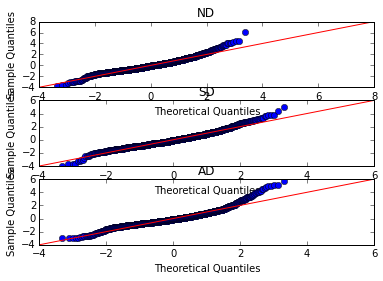

Anova statistic for group:
  F(2,7099)=5326.9280441 P=1.11022302463e-16
Means: ND: 295.268404908 (51.3203808093) S: 336.021710235 (56.3103147267) AS: 344.852033974 (81.2448685447)
SEMs: ND: 1.00493061416, S: 1.1852833264, AS: 1.71776183047

Student T test "Have the two sample means been drawn from the same population?":
 t statistic for the probability of the async statistic being generated from sync population: 7.44996874801
 t statistic for the probability of the sync statistic being generated from async population: 5.14059841277
 t statistic for the probability of the nodist statistic being generated from sync population: 34.3827542487
 t statistic for the probability of the nodist statistic being generated from async population: 28.8652525551

Normality of data:
 Shapiro-Wilks:
 No Distractor, 25 sub-samples: W 0.944206476212 p-value 0.185038909316
 Sync Distractor, 25 sub-samples: W 0.956504106522 p-value 0.349256455898
 Async Distractor, 25 sub-samples: W 0.772074103355 p-value 8

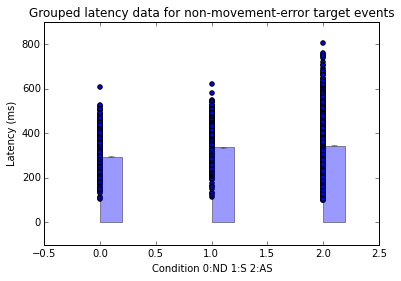

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [21]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as Pyl
from matplotlib import mlab

# Read the fname data from the octave analysis into an array of individuals
individuals = readIndividuals()

# Three containers for every event latency
nodist_latencies = [];
sync_latencies = [];
async_latencies = [];

# Populate the three containers:
for i in individuals:
    ind = individuals[i]
    # Exclude outlier latencies on a per-individual basis:
    ind.excludeOutliers()
    nodist_latencies = np.concatenate((nodist_latencies, ind.nodist_latencies[:,1]))
    sync_latencies = np.concatenate((sync_latencies, ind.sync_latencies[:,1]))
    async_latencies = np.concatenate((async_latencies, ind.async_latencies[:,1]))

# Mean, SD calculations and and standard error of the mean estimate:
means = (nodist_latencies.mean(), sync_latencies.mean(), async_latencies.mean())
stds = (nodist_latencies.std(), sync_latencies.std(), async_latencies.std())
sems = (stds[0]/np.power(nodist_latencies.size, 0.5),stds[1]/np.power(sync_latencies.size, 0.5),stds[2]/np.power(async_latencies.size, 0.5))

# Optionally make a graph:
show_graph = 1
if show_graph == 1:
    %matplotlib inline
    index = np.arange(3)
    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    # bar graph with error bars:
    rects1 = plt.bar(index, means, 0.2, alpha=opacity, color='b', yerr=sems, error_kw=error_config, label='Group data')
    # scatter points too:
    nodist_cond_x = np.zeros(nodist_latencies.size)
    sync_cond_x = np.ones(sync_latencies.size)
    async_cond_x = 2*np.ones(async_latencies.size)
    nodist_pts = plt.scatter(nodist_cond_x, nodist_latencies)
    sync_pts = plt.scatter(sync_cond_x, sync_latencies)
    async_pts = plt.scatter(async_cond_x, async_latencies)
    plt.xlabel('Condition 0:ND 1:S 2:AS')
    plt.ylabel('Latency (ms)')
    plt.title('Grouped latency data for non-movement-error target events')
    savename = 'images/group_anova.png'
    plt.savefig(savename)
    plt.show()
    # Graph done.

# Compute group ANOVA
F, dof1, dof2, P = group_anova(nodist_latencies,sync_latencies,async_latencies)
print 'Anova statistic for group:'
print '  F({0},{1})={2} P={3}'.format(dof1,dof2,F,P)
print 'Means: ND: {0} ({1}) S: {2} ({3}) AS: {4} ({5})'.format(means[0],stds[0],means[1],stds[1],means[2],stds[2])
# Standard error of mean estimates:
print 'SEMs: ND: {0}, S: {1}, AS: {2}'.format(sems[0],sems[1],sems[2])

# Student T test
print '\nStudent T test "Have the two sample means been drawn from the same population?":'
# Probability of the Sync statistic being found for the async population.
# (async_mean-sync_mean)/async_sem. With >1000 points, our confidence interval is very close to +/-1.96
t_stat_1 = (means[2] - means[1])/sems[1] # Probability of async stat being produced from sync population
t_stat_2 = (means[2] - means[1])/sems[2] # Probability of sync stat being produced from async population
print ' t statistic for the probability of the async statistic being generated from sync population:',t_stat_1
print ' t statistic for the probability of the sync statistic being generated from async population:',t_stat_2
t_stat_3 = (means[1] - means[0])/sems[1] # Probability of no-dist stat being produced from sync population
t_stat_4 = (means[2] - means[0])/sems[2] # Probability of no-dist stat being produced from async population
print ' t statistic for the probability of the nodist statistic being generated from sync population:',t_stat_3
print ' t statistic for the probability of the nodist statistic being generated from async population:',t_stat_4

print '\nNormality of data:'
print ' Shapiro-Wilks:'
W, p = stats.shapiro (subsample(nodist_latencies, 25))
print ' No Distractor, 25 sub-samples: W',W,'p-value',p
W, p = stats.shapiro (subsample(sync_latencies, 25))
print ' Sync Distractor, 25 sub-samples: W',W,'p-value',p
W, p = stats.shapiro (subsample(async_latencies, 25))
print ' Async Distractor, 25 sub-samples: W',W,'p-value',p

print '\nSee also QQ Plots (set show_graph to 1)'
# Quantile-Quantile Plot to show normality
if show_graph==1:
    f, (ax1, ax2, ax3) = plt.subplots(3)
    fig1 = sm.qqplot(nodist_latencies, fit=True, line='45',ax=ax1)
    ax1.set_title('ND')
    fig2 = sm.qqplot(sync_latencies, fit=True, line='45',ax=ax2)
    ax2.set_title('SD')
    fig3 = sm.qqplot(async_latencies, fit=True, line='45', ax=ax3)
    ax3.set_title('AD')
    savename = 'images/group_qq.png'
    plt.savefig(savename)
    plt.show()


### Analysis of Group Anova

The Anova for the grouped data suggests there's a significant variance
between the conditions. Inspection of the results suggests that the
significant difference is between no distractor and any kind of
distractor. It's not clear that there's a significant difference
between synchronous and asynchronous distractors. The T statistics
back this up. I've not reported p values for the T statistics yet
though.

## Group Anova for errors

This is a repeat of the analysis above only this time, on the errorred
movements.

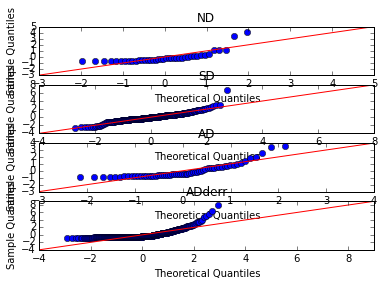

Anova statistic for group:
  F(2,418)=200.833881303 P=1.11022302463e-16
Means: ND: 267.8 (246.531559846) S: 274.670846395 (65.4136689403) AS: 229.032258065 (144.778470123) ASderr: 623.036605657 (641.412907412)
SEMs: ND: 38.9800622113, S: 3.66246233538, AS: 18.3868840925 ASderr: 26.1637782218

Student T test "Have the two sample means been drawn from the same population?":
 t statistic for the probability of the async statistic being generated from sync population: -12.4611761572
 t statistic for the probability of the sync statistic being generated from async population: -2.48212737411
 t statistic for the probability of the nodist statistic being generated from sync population: 1.87601830839
 t statistic for the probability of the nodist statistic being generated from async population: -2.10844544081

Normality of data:
 Shapiro-Wilks (p<0.05 => non-normal):
 No Distractor Target Error Movements, 25 sub-samples: W 0.590847313404 p-value 3.35906150895e-07
 Sync Target Error Movements, 

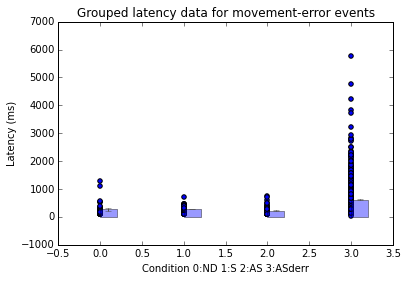

In [22]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as Pyl
from matplotlib import mlab

# Read the fname data from the octave analysis into an array of individuals
individuals = readIndividuals()

# Three containers for every error event latency
nodist_err_latencies = [];
sync_err_latencies = [];
async_err_latencies = [];
async_derr_latencies = [];

# Populate the containers:
for i in individuals:
    ind = individuals[i]
    # Exclude outlier latencies on a per-individual basis:
    ind.excludeOutliers()
    if ind.nodist_err_latencies.size>1:
        nodist_err_latencies = np.concatenate((nodist_err_latencies, ind.nodist_err_latencies[:,1]))
    if ind.sync_err_latencies.size>1:
        sync_err_latencies = np.concatenate((sync_err_latencies, ind.sync_err_latencies[:,1]))
    # For async, concatenate both target error latencies and distractor error latencies or treat them separately?
    if ind.async_err_latencies.size>1:
        async_err_latencies = np.concatenate((async_err_latencies, ind.async_err_latencies[:,1]))
    if ind.async_derr_latencies.size>1:
        async_derr_latencies = np.concatenate((async_derr_latencies, ind.async_derr_latencies[:,1]))

# Mean, SD calculations and and standard error of the mean estimate:
means = (nodist_err_latencies.mean(), sync_err_latencies.mean(), async_err_latencies.mean(), async_derr_latencies.mean())
stds = (nodist_err_latencies.std(), sync_err_latencies.std(), async_err_latencies.std(), async_derr_latencies.std())
sems = (stds[0]/np.power(nodist_err_latencies.size, 0.5),stds[1]/np.power(sync_err_latencies.size, 0.5),stds[2]/np.power(async_err_latencies.size, 0.5),stds[3]/np.power(async_derr_latencies.size, 0.5))

# Optionally make a graph:
show_graph = 1
if show_graph == 1:
    %matplotlib inline
    index = np.arange(4)
    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    # bar graph with error bars:
    rects1 = plt.bar(index, means, 0.2, alpha=opacity, color='b', yerr=sems, error_kw=error_config, label='Group data')
    # scatter points too:
    nodist_cond_x = np.zeros(nodist_err_latencies.size)
    sync_cond_x = np.ones(sync_err_latencies.size)
    async_cond_x = 2*np.ones(async_err_latencies.size)
    async_derr_cond_x = 2*np.ones(async_derr_latencies.size)
    nodist_pts = plt.scatter(nodist_cond_x, nodist_err_latencies)
    sync_pts = plt.scatter(sync_cond_x, sync_err_latencies)
    async_pts = plt.scatter(async_cond_x, async_err_latencies)
    async_derr_pts = plt.scatter(1+async_derr_cond_x, async_derr_latencies)

    plt.xlabel('Condition 0:ND 1:S 2:AS 3:ASderr')
    plt.ylabel('Latency (ms)')
    plt.title('Grouped latency data for movement-error events')
    plt.show()
    # Graph done.

# Compute group ANOVA
F, dof1, dof2, P = group_anova(nodist_err_latencies,sync_err_latencies,async_err_latencies)
print 'Anova statistic for group:'
print '  F({0},{1})={2} P={3}'.format(dof1,dof2,F,P)
print 'Means: ND: {0} ({1}) S: {2} ({3}) AS: {4} ({5}) ASderr: {6} ({7})'.format(means[0],stds[0],means[1],stds[1],means[2],stds[2],means[3],stds[3])
# Standard error of mean estimates:
print 'SEMs: ND: {0}, S: {1}, AS: {2} ASderr: {3}'.format(sems[0],sems[1],sems[2],sems[3])

# Student T test
print '\nStudent T test "Have the two sample means been drawn from the same population?":'
# Probability of the Sync statistic being found for the async population.
# (async_mean-sync_mean)/async_sem. With >1000 points, our confidence interval is very close to +/-1.96
t_stat_1 = (means[2] - means[1])/sems[1] # Probability of async stat being produced from sync population
t_stat_2 = (means[2] - means[1])/sems[2] # Probability of sync stat being produced from async population
print ' t statistic for the probability of the async statistic being generated from sync population:',t_stat_1
print ' t statistic for the probability of the sync statistic being generated from async population:',t_stat_2
t_stat_3 = (means[1] - means[0])/sems[1] # Probability of no-dist stat being produced from sync population
t_stat_4 = (means[2] - means[0])/sems[2] # Probability of no-dist stat being produced from async population
print ' t statistic for the probability of the nodist statistic being generated from sync population:',t_stat_3
print ' t statistic for the probability of the nodist statistic being generated from async population:',t_stat_4

print '\nNormality of data:'
print ' Shapiro-Wilks (p<0.05 => non-normal):'
W, p = stats.shapiro (subsample(nodist_err_latencies, 25))
print ' No Distractor Target Error Movements, 25 sub-samples: W',W,'p-value',p
W, p = stats.shapiro (subsample(sync_err_latencies, 25))
print ' Sync Target Error Movements, 25 sub-samples: W',W,'p-value',p
W, p = stats.shapiro (subsample(async_err_latencies, 25))
print ' Async Target Error Movements, 25 sub-samples: W',W,'p-value',p
W, p = stats.shapiro (subsample(async_derr_latencies, 25))
print ' Async Distractor Error Movements, 25 sub-samples: W',W,'p-value',p

print '\nSee also QQ Plots (set show_graph to 1)'
# Quantile-Quantile Plot to show normality
if show_graph==1:
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4)
    fig1 = sm.qqplot(nodist_err_latencies, fit=True, line='45',ax=ax1)
    ax1.set_title('ND')
    fig2 = sm.qqplot(sync_err_latencies, fit=True, line='45',ax=ax2)
    ax2.set_title('SD')
    fig3 = sm.qqplot(async_err_latencies, fit=True, line='45', ax=ax3)
    ax3.set_title('AD')
    fig4 = sm.qqplot(async_derr_latencies, fit=True, line='45', ax=ax4)
    ax4.set_title('ADderr')
    plt.show()


## Repeated measures ANOVA

If we collapse the replication of latency measurements into a mean
latency for each condition/individual combination, then it's possible
to perform a repeated measures ANOVA analysis. This was the original
design of the experiment and is the primary analysis reported in the
paper.

Grand mean: 327.018604194
total sos: 215033.599942 total dof: 164 total variance: 1311.18048745
total_sos: 215033.599942
condition_sos: 80551.4780108
individual_sos: 99090.3959277
remainder_sos: 35391.726004
remainder_variance: 327.701166704 remainder_sos: 35391.726004
total_sos: 215033.599942 condition_sos: 80551.4780108 indiv_sos: 99090.3959277 error (i.e. remainder): 35391.726004

F_cond:122.903862109 P_cond:1.11022302463e-16
F_ind:5.59963624925 P_ind:1.62092561595e-14

Condition:
F(2,108)=122.903862109, p=1.11022302463e-16

Between individuals:
F(54,108)=5.59963624925, p=1.62092561595e-14


Source of var, Sumof Squares, df, Mean square , F ratio         P
-------------------------------------------------------------------
Individual   , 99090.3959277, 54, 1835.00733199, 5.59963624925, 1.62092561595e-14
Condition    , 80551.4780108, 2, 40275.7390054, 122.903862109, 1.11022302463e-16
Remainder    , 35391.726004, 108, 327.701166704, -, -
Total        , 215033.599942, 164, -, -, -


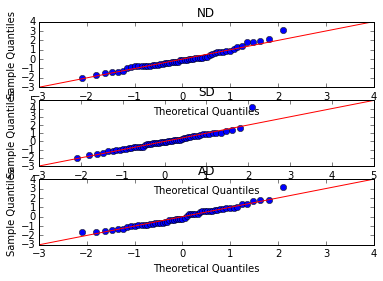


Normality of data:
 Shapiro-Wilks:
 No Distractor, 25 sub-samples: W 0.914870500565 p-value 0.0391994863749 (Reject Normal NULL hypothesis if p<alpha=0.05)
 Sync Distractor, 25 sub-samples: W 0.845669388771 p-value 0.00145912088919
 Async Distractor, 25 sub-samples: W 0.962160229683 p-value 0.459158211946

See also QQ Plots (set show_graph to 1)


In [23]:
from __future__ import division
# This repmeasures_anova works on the mean latency for each individual.
# This is effectively a "two factor anova without replication"
import numpy as np

def repmeasures_anova(individuals):

    # A one-way repeated measures anova is computed like a "two-factor anova without replication"
    # for a random block design. That means sums of squares are computed like a two factor anova.
    # This example follows McKillup Section 15.5 (p216).

    # Containers to fill
    nodist_latencies = [];
    sync_latencies = [];
    async_latencies = [];

    num_individuals = len(individuals)
    num_conditions = 3
    
    # Zeroth, exclude outliers (assumed already to have been done before this method was called)

    # In this loop extract the latencies into external containers:
    for i,ind in individuals.iteritems():
        # NB: Assume here that any outlier excluding has ALREADY been carried out.
        nodist_latencies = np.concatenate((nodist_latencies, [ind.nodist_mean()]))
        sync_latencies = np.concatenate((sync_latencies, [ind.sync_mean()]))
        async_latencies = np.concatenate((async_latencies, [ind.async_mean()]))

    # Compute grand mean
    all_latencies = np.concatenate((nodist_latencies, sync_latencies, async_latencies))
    grand_mean = all_latencies.mean()
    print 'Grand mean:',grand_mean
    
    # Displacement due to ALL sources of variation in the experiment. Factor A, Factor B, interaction, error.
    # total_variance. This is displacement from the grand mean.
    total_sos = 0
    total_dof = -1 # dof is number of replicates -1
    for i in individuals:
        ind = individuals[i]
        total_sos += np.power(grand_mean - ind.nodist_mean(), 2)
        total_sos += np.power(grand_mean - ind.sync_mean(), 2)
        total_sos += np.power(grand_mean - ind.async_mean(), 2)
    
    total_dof = (num_conditions*num_individuals)-1

    # So here's the total variance:
    total_variance = total_sos/total_dof
    print 'total sos:',total_sos,'total dof:',total_dof,'total variance:',total_variance
    # Could also get total sos with:
    # total_variance = all_latencies.var(ddof=1) # but it doesn't work as above.

    # Now consider the data in relation to each of the two factors (individual and condition)
    
    # Compute condition_plus_error_sos (Factor A - equiv to Temperature in p177 of McKillup)
    nd_treatment_mean = 0
    sd_treatment_mean = 0
    ad_treatment_mean = 0

    for i,ind in individuals.iteritems():
        nd_treatment_mean += ind.nodist_mean()
        sd_treatment_mean += ind.sync_mean()
        ad_treatment_mean += ind.async_mean()

    nd_treatment_mean = nd_treatment_mean / num_individuals
    sd_treatment_mean = sd_treatment_mean / num_individuals
    ad_treatment_mean = ad_treatment_mean / num_individuals
    
    # Now we have treatment means for each condition.
    
    condition_sos = num_individuals*(np.power(nd_treatment_mean - grand_mean,2) + np.power(sd_treatment_mean - grand_mean,2) + np.power(ad_treatment_mean - grand_mean,2))
    condition_dof = num_conditions-1 # 3 conditions - 1 = 2
    
    condition_variance = condition_sos / condition_dof
    
    # Compute individual_plus_error_sos (p178).
    individual_sos = 0
    for i,ind in individuals.iteritems():
        ind_mean = (ind.nodist_mean() + ind.sync_mean() + ind.async_mean()) / 3
        individual_sos += num_conditions*np.power(ind_mean-grand_mean,2)
    individual_dof = (num_individuals-1)
    
    individual_variance = individual_sos / individual_dof
    
    # remainder variance computed by subtraction
    ##remainder_variance = total_variance - condition_variance - individual_variance
    remainder_sos = total_sos - condition_sos - individual_sos
    print 'total_sos:', total_sos
    print 'condition_sos:', condition_sos
    print 'individual_sos:', individual_sos
    print 'remainder_sos:', remainder_sos
    remainder_dof = total_dof - condition_dof - individual_dof
    # This is the best estimate for error in a two factor ANOVA without replication:
    remainder_variance = remainder_sos/remainder_dof
    print 'remainder_variance:',remainder_variance,'remainder_sos:',remainder_sos
    
    print 'total_sos:',total_sos,'condition_sos:',condition_sos,'indiv_sos:',individual_sos,'error (i.e. remainder):',remainder_sos

    
    # Now compute the F ratios
    F_cond = condition_variance / remainder_variance # fixed. condition + error
    F_ind = individual_variance / remainder_variance # random. individual + error
    
    # Lastly, what's the probability for this?
    P_cond = 1-special.fdtr(condition_dof,remainder_dof,F_cond)
    P_ind = 1-special.fdtr(individual_dof,remainder_dof,F_ind)
    
    print '\nF_cond:{0} P_cond:{1}'.format(F_cond,P_cond)
    print 'F_ind:{0} P_ind:{1}'.format(F_ind,P_ind)
    #print 'F_interaction:{0} P_interaction:{1}'.format(F_interaction,P_interaction)
    
    print '\nCondition:\nF({0},{1})={2}, p={3}'.format(condition_dof,remainder_dof,F_cond,P_cond)
    print '\nBetween individuals:\nF({0},{1})={2}, p={3}'.format(individual_dof,remainder_dof,F_ind,P_ind)
    
    print '\n'
    print 'Source of var, Sumof Squares, df, Mean square , F ratio        ','P'
    print '-------------------------------------------------------------------'
    print '{0}, {1}, {2}, {3}, {4}, {5}'.format('Individual   ',individual_sos,individual_dof,individual_variance,F_ind,P_ind)
    print '{0}, {1}, {2}, {3}, {4}, {5}'.format('Condition    ',condition_sos,condition_dof,condition_variance,F_cond,P_cond)
    print '{0}, {1}, {2}, {3}, {4}, {5}'.format('Remainder    ',remainder_sos,remainder_dof,remainder_variance,'-','-')
    print '{0}, {1}, {2}, {3}, {4}, {5}'.format('Total        ',total_sos,total_dof,'-','-','-')

def normality_test(individuals):
    print '\nNormality of data:'

    nd_latency_means = []
    sd_latency_means = []
    ad_latency_means = []
    for i,ind in individuals.iteritems():
        nd_latency_means = np.append(nd_latency_means, ind.nodist_mean())
        sd_latency_means = np.append(sd_latency_means, ind.sync_mean())
        ad_latency_means = np.append(ad_latency_means, ind.async_mean())

    print ' Shapiro-Wilks:'
    W, p = stats.shapiro (subsample(nd_latency_means, 25))
    print ' No Distractor, 25 sub-samples: W',W,'p-value',p,'(Reject Normal NULL hypothesis if p<alpha=0.05)'
    W, p = stats.shapiro (subsample(sd_latency_means, 25))
    print ' Sync Distractor, 25 sub-samples: W',W,'p-value',p
    W, p = stats.shapiro (subsample(ad_latency_means, 25))
    print ' Async Distractor, 25 sub-samples: W',W,'p-value',p

    print '\nSee also QQ Plots (set show_graph to 1)'
    # Quantile-Quantile Plot to show normality
    show_graph = 1
    if show_graph==1:
        %matplotlib inline
        f, (ax1, ax2, ax3) = plt.subplots(3)
        fig1 = sm.qqplot(nd_latency_means, fit=True, line='45',ax=ax1)
        ax1.set_title('ND')
        fig2 = sm.qqplot(sd_latency_means, fit=True, line='45',ax=ax2)
        ax2.set_title('SD')
        fig3 = sm.qqplot(ad_latency_means, fit=True, line='45', ax=ax3)
        ax3.set_title('AD')
        savename = 'images/latency_means_normplot.png'
        plt.savefig(savename)
        plt.show()

# Call the repeated measures ANOVA
individuals = readIndividuals()

# Could equalise replicants, but this would be entirely optional for repeated measures as the latencies are averaged.
#individuals = equaliseReplicates(individuals)
# If we don't call equalise, then must exclude outliers anyway:
for i,ind in individuals.iteritems():
    ind.excludeOutliers()

normality_test(individuals)

repmeasures_anova(individuals)

### Repeated Measures ANOVA repeated in SPSS for validation

Let's export the numbers out to SPSS and run the test there. We'll get
some additional numbers for free, such as the estimated effect size,
and some Bonferroni tests (which are based on t-tests).

In [13]:
block_enabled = 0
if block_enabled:
    individuals = readIndividuals()

    print "'ID','Latency_ND','Latency_SD','Latency_AD'"
    for i,ind in individuals.iteritems():
        ind.outputDataForSPSS_RepMeasLat()

Copy and paste the text generated by the previous block into a file,
and import it into SPSS. Run a One-way Repeated measures ANOVA. See
One_Way_Repeated_Meas_Latency.csv (copied and pasted from the above)
One_Way_Repeated_Meas_Latency.sav (data after SPSS import) and
One_Way_Repeated_Meas_Latency.spv (SPSS report). See, for example,
https://statistics.laerd.com/spss-tutorials/one-way-anova-repeated-measures-using-spss-statistics.php

#### Results

There were no differences in the results. The SPSS result for the ANOVA is

F(2,108) = 53.215, p<0.0005

My result for the ANOVA without applying the equaliseReplicates code matches.

I will also report the additional statistical tests which SPSS
performed for me; Mauchly's test of Sphericity, the estimation of
effect size and the Bonferroni post-hoc tests (these last of which
agree with my Tukey post-hoc tests in the factorial ANOVA).

Mauchly: $\chi^2$(2)=2.614, p=0.271

Effect size: Partial $\eta^2$=0.496

##### 20160706 Note

This needs updating if I'm going to report Mauchly and partial eta.

#### Partial $\omega^2$

SPSS gives partial $\eta^2$ but not partial $\omega^2$. Calculate the
latter like this:

In [14]:
from __future__ import division
# Compute partial omega squared
num_cond=3
F=53.215
num_individuals=56
omega_squared = (num_cond-1)*(F-1)/((num_cond-1)*(F-1)+(num_individuals*num_cond))
print 'omega_squared for condition=',omega_squared

F=3.455
omega_squared = (num_individuals-1)*(F-1)/((num_individuals-1)*(F-1)+(num_cond*num_individuals))
print 'omega_squared for individual=',omega_squared

omega_squared for condition= 0.383327827332
omega_squared for individual= 0.44559029783


## Two factor ANOVA summary

### Repeated measures

The null hypotheses are that "condition does not change latency" and
"individual does not affect latency".

A repeated measures anova, where I use the mean latency for each
condition as a single data point for each individual shows a
significant effect both for condition and for individual - the null
hypotheses must be rejected in each case.

SPSS gives us some additional statistics (add these here).

## Analysis of Movement Errors

It's possible to count the number of errors which the subject makes
when following the target. In some trials, the subject will mistakenly
begin to move towards the distractor line, before correcting
(sometimes after a very short period of time) to move towards the
target. I wanted to see whether the synchronous distractor or the
asynchronous distractor produce more errors, but it is hard to
compare. In the synchronous distractor case, there are always the same
number of distractor events as target events. In the asynchronous
distractor case, there may be more distractor events (or fewer) than
target events. To overcome this problem, I report the number of errors
per distractor event.

In [29]:
# How to show the number of errors per distractor for an individual:
individuals = readIndividuals()
i = 'SB1'
ind = individuals[i]
print 'Individual',i
print '  ND errors per target:',ind.num_tmoveerrors_percent(0),'%'
print '  Sync errors per target:',ind.num_tmoveerrors_percent(1),'%'
print '  Async errors per target:',ind.num_tmoveerrors_percent(2),'%'
print '  Async errors per distractor:',ind.num_dmoveerrors_percent(2),'%'

# Also:
#ind.report_movements(0)
#ind.report_movements(1)
#int.report_movements(2)

Individual SB1
  ND errors per target: 2.04081632653 %
  Sync errors per target: 13.0434782609 %
  Async errors per target: 0 %
  Async errors per distractor: 7.24637681159 %


The numbers above do show a speed accuracy tradeoff effect. In the
group which were faster to respond to synchronous distractors,
sync. error rates were higher, in the group which were faster for
async, error rates for async were higher. Likewise, in the group which
were faster to respond to synchronous distractors, async error rates
were lower and in the group which were faster for async, error rates
for sync were lower. In both the groups that were faster for one or
other of the distractor conditions, ND error rates were slightly
higher than the group mean.

This is the core of the movement error analysis. Here, I compute move
errors for the group and for the identified groups from the individual
analysis. I compute mean and mad/SD for the error rates, but attempt
no kind of analysis of variances because the movement errors for the
Async condition are not comparable with those for the ND/SD
conditions. I _could_ do a Wilcoxon test between the ND and SD
condition though. See Err.r for that test.

In [46]:
# NB: The code in readIndividuals() collects numbers of errors per distractor event.
# fasterSyncSubjects is a global created in a code block above (see around "Individual Anova").
individuals = readIndividuals()


print '\n==========\n\nGROUP MEAN Error rates'

nd_list = []
sync_list = []
async_list = []

for i,ind in individuals.iteritems():
    nd_list.append(float(ind.num_moveerrors_per_target_percent(0)))
    sync_list.append(float(ind.num_moveerrors_per_target_percent(1)))
    async_list.append(float(ind.num_moveerrors_per_target_percent(2)))

if len(individuals)>0:
    print 'ND error rate per subj:',np.mean(nd_list),'+/-',np.std(nd_list),'(SD)',compute_mad(np.array(nd_list)),'(MAD)'
    print 'SD error rate per subj:',np.mean(sync_list),'+/-',np.std(sync_list),'(SD)',compute_mad(np.array(sync_list)),'(MAD)'
    print 'AD error rate per subj:',np.mean(async_list),'+/-',np.std(async_list),'(SD)',compute_mad(np.array(async_list)),'(MAD)'


print '\n=============================================='
print 'NB: Groups computed in R using source(\'Ind.r\')'
print '=============================================='

# Update to the note above. An R analysis in Ind.r where the wilcoxon
# signed rank test was applied produces the following faster/slower groups:
fasterSyncSubjects = ['CD1','CD2','CP','EC1','EC2','EF','IR','RF','RQ','SB2']
noDiffSubjects = ['AB1_','AM','AS','AW1_','AW2_','AW3_','BG','CH','CM','EB1','EB2','EK','EM2','EW1_','EW2_','GB','GM','HY','IB','JF','JS','JT1','JT2','KC','KR','LH2','LK_','LS','MC','NC','PB','PO','RC','RD','RG','SB1','SF','SS','SY','TC','TM']
fasterAsyncSubjects = ['NA','LH1','EJ','AL_']

print ''
print 'FASTER SYNC GROUP - mean error rates'

nd_list = []
sync_list = []
async_list = []

for i in fasterSyncSubjects:
    ind = individuals[i]
    nd_list.append(float(ind.num_moveerrors_per_target_percent(0)))
    sync_list.append(float(ind.num_moveerrors_per_target_percent(1)))
    async_list.append(float(ind.num_moveerrors_per_target_percent(2)))

print 'Group size:',len(fasterSyncSubjects)

if len(fasterSyncSubjects)>0:
    #print 'ND error rates all:',nd_list
    print 'ND error rate per subj:',np.mean(nd_list),'+/-',np.std(nd_list),'(SD)',compute_mad(np.array(nd_list)),'(MAD)'
    print 'SD error rate per subj:',np.mean(sync_list),'+/-',np.std(sync_list),'(SD)',compute_mad(np.array(sync_list)),'(MAD)'
    print 'AD error rate per subj:',np.mean(async_list),'+/-',np.std(async_list),'(SD)',compute_mad(np.array(async_list)),'(MAD)'

print '\nNO DIFF GROUP - mean error rates'

nd_list = []
sync_list = []
async_list = []

for i in noDiffSubjects:
    ind = individuals[i]
    nd_list.append(float(ind.num_moveerrors_per_target_percent(0)))
    sync_list.append(float(ind.num_moveerrors_per_target_percent(1)))
    async_list.append(float(ind.num_moveerrors_per_target_percent(2)))

print 'Group size:',len(noDiffSubjects)

if len(noDiffSubjects)>0:
    #print 'ND error rates all:',nd_list
    print 'ND error rate per subj:',np.mean(nd_list),'+/-',np.std(nd_list),'(SD)',compute_mad(np.array(nd_list)),'(MAD)'
    print 'SD error rate per subj:',np.mean(sync_list),'+/-',np.std(sync_list),'(SD)',compute_mad(np.array(sync_list)),'(MAD)'
    print 'AD error rate per subj:',np.mean(async_list),'+/-',np.std(async_list),'(SD)',compute_mad(np.array(async_list)),'(MAD)'

print '\nFASTER ASYNC GROUP - mean error rates'

nd_list = []
sync_list = []
async_list = []

for i in fasterAsyncSubjects:
    ind = individuals[i]
    nd_list.append(float(ind.num_moveerrors_per_target_percent(0)))
    sync_list.append(float(ind.num_moveerrors_per_target_percent(1)))
    async_list.append(float(ind.num_moveerrors_per_target_percent(2)))

print 'Group size:',len(fasterAsyncSubjects)

if len(fasterAsyncSubjects)>0:
    print 'ND error rate per subj:',np.mean(nd_list),'+/-',np.std(nd_list),'(SD)',compute_mad(np.array(nd_list)),'(MAD)'
    print 'SD error rate per subj:',np.mean(sync_list),'+/-',np.std(sync_list),'(SD)',compute_mad(np.array(sync_list)),'(MAD)'
    print 'AD error rate per subj:',np.mean(async_list),'+/-',np.std(async_list),'(SD)',compute_mad(np.array(async_list)),'(MAD)'



GROUP MEAN Error rates
ND error rate per subj: 1.62539001701 +/- 2.31535597495 (SD) 0.0 (MAD)
SD error rate per subj: 12.5197119283 +/- 7.90666623658 (SD) 5.34188034188 (MAD)
AD error rate per subj: 30.1797973648 +/- 13.3714791084 (SD) 8.23170731707 (MAD)

NB: Groups computed in R using source('Ind.r')

FASTER SYNC GROUP - mean error rates
Group size: 10
ND error rate per subj: 1.7199425339 +/- 2.68868197946 (SD) 0.0 (MAD)
SD error rate per subj: 13.7275196723 +/- 6.25888360262 (SD) 4.45601679644 (MAD)
AD error rate per subj: 27.259995935 +/- 13.0007010711 (SD) 8.43843843844 (MAD)

NO DIFF GROUP - mean error rates
Group size: 41
ND error rate per subj: 1.59055850274 +/- 2.24662923602 (SD) 0.0 (MAD)
SD error rate per subj: 12.4722687325 +/- 8.38419533689 (SD) 5.66037735849 (MAD)
AD error rate per subj: 29.3610641874 +/- 10.2921098429 (SD) 7.83783783784 (MAD)

FASTER ASYNC GROUP - mean error rates
Group size: 4
ND error rate per subj: 1.74603174603 +/- 1.96338363125 (SD) 1.11111111111 

## Validate in SPSS

Here's a section of code which outputs the data in a CSV file format
which can be imported into SPSS.

In [17]:
block_enabled = 0
if block_enabled:
    # Output data in format suitable for SPSS
    individuals = readIndividuals()

    # Optional:
    individuals = equaliseReplicates(individuals)

    for i,ind in individuals.iteritems():
        ind.outputDataForSPSS()


### Output data for analysis in R

How many different stats systems can we use for one piece of data
analysis? Here's a csv file suitable for analysis in R. See Anova.r
for the script to process this to produce the non-parametric repeated
measures Anova.

In [48]:
block_enabled = 0
if block_enabled:
    # Output data in format suitable for SPSS - multivariate analysis
    individuals = readIndividuals()

    # Optional:
    #individuals = equaliseReplicates(individuals)
    # or
    # If we don't call equalise, exclude outliers anyway:
    for i,ind in individuals.iteritems():
        ind.excludeOutliers()
    
    print "idnum,latency,condition,condition_str,subj_id"
    for i,ind in individuals.iteritems():
        csvdata += ind.outputDataForR()

    print 'Writing AnovaR.csv...'
    f = open('AnovaR.csv', 'w')
    f.write(csvdata)
    f.close()

## Show which events are outliers

In [49]:
print 'Showing latency outlier event numbers and values'
print '------------------------------------------------'
individuals = readIndividuals()
show_excluded = 1
for i,ind in individuals.iteritems():
    ind.excludeOutliers(show_excluded)

 [ 39.] which have values [ 1316.]
exclude async latencies for subject  SF filename Jon/SF/line/20141125145313.txt
Excluding error outliers...
exclude nodist latencies for subject  SF filename Jon/SF/line/20141125145758.txt
exclude sync latencies for subject  SF filename Jon/SF/line/20141125145535.txt
exclude async latencies for subject  SF filename Jon/SF/line/20141125145313.txt
Excluding good movement outliers...
exclude nodist latencies for subject  GB filename Rachel/GB/line/20141118153448.txt
deleting the following events [ 8.] which have values [ 466.]
exclude sync latencies for subject  GB filename Rachel/GB/line/20141118153713.txt
exclude async latencies for subject  GB filename Rachel/GB/line/20141118153932.txt
Excluding error outliers...
exclude nodist latencies for subject  GB filename Rachel/GB/line/20141118153448.txt
exclude sync latencies for subject  GB filename Rachel/GB/line/20141118153713.txt
exclude async latencies for subject  GB filename Rachel/GB/line/201411181539

 AW2_ filename Katie/AW2_/line/20141201133936.txt
Excluding error outliers...
exclude nodist latencies for subject  AW2_ filename Katie/AW2_/line/20141201133652.txt
exclude sync latencies for subject  AW2_ filename Katie/AW2_/line/20141201134221.txt
exclude async latencies for subject  AW2_ filename Katie/AW2_/line/20141201133936.txt
Excluding good movement outliers...
exclude nodist latencies for subject  RF filename Katie/RF/line/20141201142950.txt
exclude sync latencies for subject  RF filename Katie/RF/line/20141201143224.txt
deleting the following events [ 2.] which have values [ 100.]
exclude async latencies for subject  RF filename Katie/RF/line/20141201142720.txt
Excluding error outliers...
exclude nodist latencies for subject  RF filename Katie/RF/line/20141201142950.txt
exclude sync latencies for subject  RF filename Katie/RF/line/20141201143224.txt
exclude async latencies for subject  RF filename Katie/RF/line/20141201142720.txt
Excluding good movement outliers...
exclude no

Showing latency outlier event numbers and values
------------------------------------------------
Excluding good movement outliers...
exclude nodist latencies for subject  SB2 filename Olivia/SB2/line/20141204145931.txt
exclude sync latencies for subject  SB2 filename Olivia/SB2/line/20141204145711.txt
exclude async latencies for subject  SB2 filename Olivia/SB2/line/20141204150147.txt
Excluding error outliers...
exclude nodist latencies for subject  SB2 filename Olivia/SB2/line/20141204145931.txt
exclude sync latencies for subject  SB2 filename Olivia/SB2/line/20141204145711.txt
deleting the following events [ 18.] which have values [ 141.]
exclude async latencies for subject  SB2 filename Olivia/SB2/line/20141204150147.txt
Excluding good movement outliers...
exclude nodist latencies for subject  HY filename Rachel/HY/line/20141118151002.txt
deleting the following events [ 10.] which have values [ 640.]
exclude sync latencies for subject  HY filename Rachel/HY/line/20141118150740.txt


## Reproduce Summary Spreadsheet for comparison with Mauro's analysis
Mauro has Summary.xls, which lists the following columns:

Experimenter    Subject    Distractor type    RT (M)    RT (SD)    N correct    RT incorrect (M)    RT incorrect (SD)    N incorrect    Error rate    Delays (negative = incorrect)


In [47]:
# Output data in format suitable for R
individuals = readIndividuals()

# Optional:
#individuals = equaliseReplicates(individuals)
# or
# If we don't call equalise, exclude outliers anyway:
for i,ind in individuals.iteritems():
    ind.excludeOutliers()

csvdata = 'idnum,latency,condition,condition_str,subj_id\n'
for i,ind in individuals.iteritems():
    csvdata += ind.outputDataForR()
    # Save this particular individuals latency values
    ind.writeDataForR()

print 'Writing AnovaR.csv...'
f = open('AnovaR.csv', 'w')
f.write(csvdata)
f.close()

print 'Writing error_rates.csv...'
f = open('error_rates.csv', 'w')
f.write ('idnum,error_rate,condition,condition_str,subj_id\n')
for i,ind in readIndividuals().iteritems():
    subj_id = ind.subj_id
    if subj_id == 'NA':
        subj_id = 'NA_'
    f.write ('{0},{1},1,ND,{2}\n'.format(ind.idnum,ind.num_moveerrors_per_target(0),subj_id))
    f.write ('{0},{1},2,SD,{2}\n'.format(ind.idnum,ind.num_moveerrors_per_target(1),subj_id))
    f.write ('{0},{1},3,AD,{2}\n'.format(ind.idnum,ind.num_moveerrors_per_target(2),subj_id))
f.close()


Writing AnovaR.csv...
Writing error_rates.csv...


In [0]:
# Output each individuals'

In [20]:
from __future__ import division
import numpy as np
from statsmodels.stats.multicomp import MultiComparison

maxCount = 100 # 1 for debug or 100 for all
count = 1
csvdata = ''

individuals = readIndividuals()

for i in individuals:
    ind = individuals[i]

    if count == 1:
        csvdata = ind.csvheader()
    
    # Remove outliers in standard way
    ind.excludeOutliers()

    csvdata += ind.csvlineset()

    # For debugging, break after maxCount
    if count >= maxCount:
        break
    count += 1

print 'Writing Summary.csv...'
f = open('Summary.csv', 'w')
f.write(csvdata)
f.close()

AttributeError: individual instance has no attribute 'omit_reason'

## Reading Mauro's data

Using Mathematica, Mauro has coded his own version of the Octave
scripts that I wrote. I want to incorporate his numbers into my
analysis. That means reading his spreadsheet into my list of
individuals. I'll code up a readMauroData() function to do this. I'll
have to convert his excel spreadsheet into csv so it can be read in.